# Finding GCs - 

The function of this code is to perform all the processes required to find GCs (Globular Clusters) in an astronomical image, **including image analysis, source extraction, and selection of the correct criteria for identifying the globular clusters.**

code by Raimundo Ferreira

In [1]:
from astroquery.vizier import Vizier
from astropy.convolution import Gaussian2DKernel, convolve
import astropy.io.fits as fits
from astropy.io import fits
from astropy.io import ascii
import astropy.units as u
from scipy.stats import norm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Polygon
from matplotlib.path import Path
from matplotlib.patches import Ellipse
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
import pandas as pd
from pyraf import iraf
from iraf import images, immatch
from tqdm import tqdm
import subprocess
import os
import math

###

### Inputing - 

**The first step is input all the necesary params to use the code.** <br>
For using this code, you need to **input the directory where the original images are, inside that the folder that will be used to write the filtered images.**

**Input the folder name too and the galaxy name for simplify the code:**

In [ ]:
def main(galaxy_name, gaussian_sigma, images_dpi, images_format):

In [2]:
# ESO410-018 - NGC2101 - ESO159-025 - ESO249-026 - ESO362-009 - ESO245-005 - IC1574 - ESO149-003 - ESO302-014 - NGC7064 - NGC7462
galaxy_name = "IC1574"
sigma = 8 #px
d = 1500

**Input the gaussian sigma, that will used to smooth the images: (VALUES: 3.5 - 5 - 8) - we are using 8px now**

**Set the dpi of the images plots:**

###

### Defining some configurations:

In [3]:
#Raw galaxy images
#input_directory = input("Folder directory:")
folder_name = "Filter"
input_directory = "/home/raimundo/Documentos/UFRJ/IC/Imagens_GC/" + galaxy_name 
IR_input_directory = input_directory + "/Infrared"
UV_input_directory = input_directory + "/UV" 

In [4]:
#Catalog output, the same of the configuration file
directory = "/home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/" + galaxy_name + "/"

#.fits galaxy image
fits_dir = "/home/raimundo/Documentos/UFRJ/IC/Imagens_GC/" + galaxy_name + "/" + galaxy_name + "_g.fits" 
image = fits.open(fits_dir)[0].data.astype(float) 

In [5]:
#Where the final caltalog will are saved?
f_directory = "/home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/" + galaxy_name + "/" + "candidatos_finais_" + galaxy_name + ".dat"
#Where the plots will are saved?
p_directory = "/home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/" + galaxy_name + "/" + "Plots/"

In [6]:
output_directory = "/home/raimundo/Documentos/UFRJ/IC/Imagens_GC/Combined_images"
image_output_name = "optical_combine_" + galaxy_name + ".fits"

###

### Star models -

Now, we need to set the star model file. Generally, **we use models from: http://stev.oapd.inaf.it/cgi-bin/cmd**. Finally, the catalog should have a **header that is identical to the one shown below**, and the **image names should be in the format of age.dat (for example: 135.cat, 9.cat)**.

In [7]:
# age Z mbolmag umag gmag rmag imag zmag Ymag

In [8]:
star_directory = "/home/raimundo/Documentos/UFRJ/IC/Star model/"

#This codes reads the star models
data135 = ascii.read(star_directory + '135.dat')
data10 = ascii.read(star_directory +'10.dat')
data9 = ascii.read(star_directory +'9.dat')
data6 = ascii.read(star_directory + '6.dat')

###

### Galaxy params

We define a .csv file, contain the importat params of the galaxy, like RA and DEC, name, effective radius and concentration param previously measured

In [9]:
galaxy_params = pd.read_csv("/home/raimundo/galaxy_params.csv", sep=" ")
galaxy_params

nome     dis   r_eff  x_pix  y_pix  centerx  centery  \
0             ESO410-018  19.000   29.72   2264   2264   1132.0   1132.0   
1                NGC2101  13.300   47.78   5186   6867   1750.0   3500.0   
2             ESO159-025  11.800   28.40   2164   2269   1082.0   1134.5   
3             ESO249-026   9.500   31.67   1852   1852    926.0    926.0   
4             ESO362-009  10.200   69.05   4111   4111   2055.5   2055.5   
5             ESO245-005   4.193  103.00   4107   4107   2053.0   2053.0   
6                 IC1574   4.773   52.43   2735   2735   1367.0   1367.0   
7             ESO149-003   6.250   26.05   2280   2280   1140.0   1140.0   
8             ESO302-014   9.300   29.88   2283   2283   1141.0   1141.0   
9                NGC7064  11.350   50.58   2739   2739   1369.0   1369.0   
10               NGC7462  12.252   51.27   2736   2736   1368.0   1368.0   
11  ESO410-018_no_galaxy  19.000   29.72   2264   2264   1132.0   1132.0   
12     NGC2101_no_galaxy  13.300   47.78   2264   2264   1132.0   1132.0   
13  ESO159-025_no_galaxy  11.800   28.40   2164   2269   1082.0   1134.5   
14  ESO249-026_no_galaxy   9.500   31.67   1852   1852    926.0    926.0   
15  ESO362-009_no_galaxy  10.200   69.05   4111   4111   2055.5   2055.5   
16      IC1574_no_galaxy   4.773   52.43   2735   2735   1367.0   1367.0   
17  ESO149-003_no_galaxy   6.250   26.05   2280   2280   1140.0   1140.0   
18  ESO302-014_no_galaxy   9.300   29.88   2283   2283   1141.0   1141.0   
19     NGC7064_no_galaxy  11.350   50.58   2739   2739   1369.0   1369.0   
20     NGC7462_no_galaxy  12.252   51.27   2736   2736   1368.0   1368.0   

    concentration     r                 RA DEC   err  
0            0.62  1.80    8.546689 -30.773603  10.0  
1            0.71  1.95   86.600708 -52.088528   NaN  
2            0.73  2.00   85.775944 -52.700454   NaN  
3            0.77  2.00   58.553770 -43.757753   NaN  
4            0.60  1.80   77.997186 -32.972625   NaN  
5            0.00  1.80   26.266250 -43.598528   NaN  
6            0.00  1.90   10.764863 -22.243127   NaN  
7            0.00  1.90  358.010261 -52.576188   NaN  
8            0.00  1.80   57.920005 -38.452847   NaN  
9            0.00  2.00  322.262504 -52.767653   NaN  
10           0.00  2.00  345.693589 -40.835504   NaN  
11           0.62  1.75    8.546689 -30.773603   NaN  
12           0.71  1.85   86.600708 -52.088528   NaN  
13           0.73  1.80   85.775944 -52.700454   NaN  
14           0.77  2.00   58.553770 -43.757753   NaN  
15           0.60  1.95   77.997186 -32.972625   NaN  
16           0.00  1.90   10.764863 -22.243127   NaN  
17           0.00  1.90  358.010261 -52.576188   NaN  
18           0.00  1.80   57.920005 -38.452847   NaN  
19           0.00  2.00  322.262504 -52.767653   NaN  
20           0.00  1.80  345.693589 -40.835504   NaN

In [10]:
dis = float(np.array(galaxy_params[galaxy_params["nome"] == galaxy_name]["dis"])[-1])
effective_radius = float(np.array(galaxy_params[galaxy_params["nome"] == galaxy_name]["r_eff"])[-1])
x_pix = float(np.array(galaxy_params[galaxy_params["nome"] == galaxy_name]["x_pix"])[-1])
y_pix = float(np.array(galaxy_params[galaxy_params["nome"] == galaxy_name]["y_pix"])[-1])
cord = str(np.array(galaxy_params[galaxy_params["nome"] == galaxy_name]["RA DEC"])[-1])
r = float(np.array(galaxy_params[galaxy_params["nome"] == galaxy_name]["r"])[-1])

###

### 1. Image processing

To start, we perform all the image processing. The foundation of this section is filtering and applying image convolution. After that, we also create a combined image, which will be used by the Source Extractor.

#### Images subtraction:

In [11]:
a = 1

# This part open the images folder and remove the filtered image folder from the list
galaxy_images = os.listdir(input_directory)
list.remove(galaxy_images, folder_name)
list.remove(galaxy_images, "Infrared")
list.remove(galaxy_images, "UV")

# This code open the .fits data for all the images
for images in tqdm(galaxy_images):
    directory_image = input_directory + "/" + images
    if(a == 1):
        image_data1,header1 = fits.getdata(directory_image , header=True)
        name1 = images
    if(a == 2):
        image_data2,header2 = fits.getdata(directory_image , header=True)
        name2 = images
    if(a == 3):
        image_data3,header3 = fits.getdata(directory_image , header=True)  
        name3 = images
    if(a == 4):	
        image_data4,header4 = fits.getdata(directory_image , header=True)
        name4 = images
    if(a == 5):
        image_data5,header5 = fits.getdata(directory_image , header=True)
        name5 = images
    a = a + 1

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 959.52it/s]


In [12]:
name_out = input_directory + '/' + folder_name + '/' + galaxy_name + "_filtradas.fits"

def subtract (image_, image_header,sigma ,output_name):
    name_out = input_directory + '/' + folder_name + '/' + galaxy_name + "_filtradsas.fits"
    # The number in the Gausian2DKernel is the sigma used to filter the image
    gaussian = Gaussian2DKernel(sigma)
    image_convolved = convolve(image_, gaussian)
    fits.writeto("/home/raimundo/suAVI.fits", image_convolved,overwrite=True)
    
    #fits.writeto(image_convolved, image_header, overwrite=True)
    # In this line, the original image is subtracted of the filtered image
    final = image_ - image_convolved
    
    # Finally, the image is writed in the folder used to store them
    fits.writeto(output_name, final, image_header, overwrite=True)

That function returns the new image that will be smoothed by subtraction of the original image for the image convolved , with the Gaussian filter. The Gaussian sigma comes from of the PSF of the image, that is a multiple of Full Width at Half Maximum (FWHM) <b>. In my research, the sigma most used is: 3.5 for optical and 3 to infrared.</b>

In [13]:
a = 1
initial_directory = input_directory + '/' + folder_name + '/'

# To finish, this board code apply the "subtract" for the all images in the folder.
while(a != 6):	
    if(a == 1):
        final_image = image_data1
        final_header = header1
        name_out = initial_directory + name1 + "_filtradas.fits"
    if(a == 2):
        final_image = image_data2
        final_header = header2
        name_out = initial_directory + name2 + "_filtradas.fits"
    if(a == 3):
        final_image = image_data3
        final_header = header3
        name_out = initial_directory + name3 + "_filtradas.fits"
    if(a == 4):
        final_image = image_data4
        final_header = header4
        name_out = initial_directory + name4 + "_filtradas.fits"

    subtract(final_image, final_header, float(sigma), name_out)
    print(str((a-1) * 25) + "%" + " completed!")
    a = a + 1
    
print("Complete!")

0% completed!
25% completed!
50% completed!
75% completed!
100% completed!
Complete!


####

#### Combine images:

In this section, the images opened will be combined, the proposal is to sum images in different bands.

In [14]:
images_directory = input_directory + '/' + folder_name + '/'

list_directory = os.listdir(images_directory)
#list.remove(list_directory, "Filter") # Remove any folder that bug the code
list_directory

['IC1574_i.fits_filtradas.fits',
 'IC1574_g.fits_filtradas.fits',
 'IC1574_z.fits_filtradas.fits',
 'IC1574_r.fits_filtradas.fits']

In [15]:
directory_ = ""
lenght = 0
a = True

for value in tqdm(list_directory):
    if(lenght != len(list_directory) - 1):
        directory_ = directory_ + images_directory +  value + ','
    else:
        directory_ = directory_ + images_directory + value
    lenght = lenght + 1

100%|█████████████████████████████████████████| 4/4 [00:00<00:00, 100462.37it/s]


**Finishing, using the IRAF package, the images selected will be sum, and the final image stored in a directory that you chose.**

In [16]:
# Combine images
out = (output_directory + "/" + image_output_name)
iraf.imcombine(directory_, output=out, combine='median')

###

### 2.Run SExtractor

We will run the software SExtractor in the terminal using Python code, for that, some prerequisites are necessary. <br>
**Filters, and files, including the configuration file, need to be in the personal folder (Linux).**

In [17]:
#Navegating for the personal folder
config_file_dir = "/home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/" 
os.chdir("/home/raimundo/")

#Defining the filters and the configuration files
filters = ["g", "r", "r","i", "z"]
configs = ["g", "r", "r6","i", "z"]

#Run the comand for each band and configuration file
for band in tqdm(range(0, len(filters))):
    comando = "sex " + input_directory + "/" +  galaxy_name + "_" + filters[band] + ".fits" + " -c " + config_file_dir + galaxy_name + "/config/" + "prepsfex_" + configs[band] + ".sex"
    print(comando)
    subprocess.run(comando, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

sex /home/raimundo/Documentos/UFRJ/IC/Imagens_GC/IC1574/IC1574_g.fits -c /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/config/prepsfex_g.sex


 20%|█████████                                    | 1/5 [00:01<00:04,  1.14s/it]

sex /home/raimundo/Documentos/UFRJ/IC/Imagens_GC/IC1574/IC1574_r.fits -c /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/config/prepsfex_r.sex


 40%|██████████████████                           | 2/5 [00:02<00:04,  1.34s/it]

sex /home/raimundo/Documentos/UFRJ/IC/Imagens_GC/IC1574/IC1574_r.fits -c /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/config/prepsfex_r6.sex


 60%|███████████████████████████                  | 3/5 [00:03<00:02,  1.33s/it]

sex /home/raimundo/Documentos/UFRJ/IC/Imagens_GC/IC1574/IC1574_i.fits -c /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/config/prepsfex_i.sex


 80%|████████████████████████████████████         | 4/5 [00:05<00:01,  1.27s/it]

sex /home/raimundo/Documentos/UFRJ/IC/Imagens_GC/IC1574/IC1574_z.fits -c /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/config/prepsfex_z.sex


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]


In [18]:
from astropy.table import Table

file_g = config_file_dir + galaxy_name + "/" + "sources_prepsfex_" + configs[0] + ".cat"
file_r = config_file_dir + galaxy_name + "/" + "sources_prepsfex_" + configs[1] + ".cat"
file_r6 = config_file_dir + galaxy_name + "/" + "sources_prepsfex_" + "r_6" + ".cat"
file_i = config_file_dir + galaxy_name + "/" + "sources_prepsfex_" + configs[3] + ".cat"
file_z = config_file_dir + galaxy_name + "/" + "sources_prepsfex_" + configs[4] + ".cat"

data_g = fits.open(file_g)
tabela = Table(data_g[2].data)
tabela_filtrada = tabela[(tabela['ELONGATION'] <= 1.1) & (tabela['ELONGATION'] >= 0.9)]
hdu_filtrado = fits.BinTableHDU(tabela_filtrada, header=data_g[2].header)
data_g[2] = hdu_filtrado
data_g.writeto(config_file_dir + galaxy_name + "/" + "sources_prepsfex_" + configs[0] + ".cat", overwrite=True)
data_g.close()

data_r = fits.open(file_r)
tabela = Table(data_r[2].data)
tabela_filtrada = tabela[(tabela['ELONGATION'] <= 1.1) & (tabela['ELONGATION'] >= 0.9)]
hdu_filtrado = fits.BinTableHDU(tabela_filtrada, header=data_r[2].header)
data_r[2] = hdu_filtrado
data_r.writeto(config_file_dir + galaxy_name + "/" + "sources_prepsfex_" + configs[1] + ".cat", overwrite=True)
data_r.close()

data_i = fits.open(file_i)
tabela = Table(data_i[2].data)
tabela_filtrada = tabela[(tabela['ELONGATION'] <= 1.1) & (tabela['ELONGATION'] >= 0.9)]
hdu_filtrado = fits.BinTableHDU(tabela_filtrada, header=data_i[2].header)
data_i[2] = hdu_filtrado
data_i.writeto(config_file_dir + galaxy_name + "/" + "sources_prepsfex_" + configs[3] + ".cat", overwrite=True)
data_i.close()

data_r6 = fits.open(file_r6)
tabela = Table(data_r6[2].data)
tabela_filtrada = tabela[(tabela['ELONGATION'] <= 1.1) & (tabela['ELONGATION'] >= 0.9)]
hdu_filtrado = fits.BinTableHDU(tabela_filtrada, header=data_r6[2].header)
data_r6[2] = hdu_filtrado
data_r6.writeto(config_file_dir + galaxy_name + "/" + "sources_prepsfex_" + "r_6" + ".cat", overwrite=True)
data_r6.close()

data_z = fits.open(file_z)
tabela = Table(data_z[2].data)
tabela_filtrada = tabela[(tabela['ELONGATION'] <= 1.1) & (tabela['ELONGATION'] >= 0.9)]
#r_test = tabela_filtrada['ELONGATION']
#flux_test = tabela_filtrada['FLUX_APER']
#plt.scatter(r_test, np.log10(flux_test))
#tabela_filtrada
hdu_filtrado = fits.BinTableHDU(tabela_filtrada, header=data_z[2].header)
data_z[2] = hdu_filtrado
data_z.writeto(config_file_dir + galaxy_name + "/" + "sources_prepsfex_" + configs[4] + ".cat", overwrite=True)
data_z.close()

In [19]:
#Navegating for the personal folder
config_file_dir = "/home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/" 
os.chdir("/home/raimundo/")

#Defining the filters and the configuration files
filters = ["g", "r", "r6","i", "z"]
configs = ["g", "r", "r_6","i", "z"]

#Run the comand for each band and configuration file
for band in tqdm(range(0, len(filters))):
    comando = "psfex " + " " + config_file_dir + galaxy_name + "/" + "sources_prepsfex_" + configs[band] + ".cat" + " -c " + config_file_dir + galaxy_name + "/config/" +  "default.psfex" 
    print(comando)
    subprocess.run(comando, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

psfex  /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/sources_prepsfex_g.cat -c /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/config/default.psfex


 20%|█████████                                    | 1/5 [00:01<00:07,  1.99s/it]

psfex  /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/sources_prepsfex_r.cat -c /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/config/default.psfex


 40%|██████████████████                           | 2/5 [00:03<00:05,  1.96s/it]

psfex  /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/sources_prepsfex_r_6.cat -c /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/config/default.psfex


 60%|███████████████████████████                  | 3/5 [00:05<00:03,  1.96s/it]

psfex  /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/sources_prepsfex_i.cat -c /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/config/default.psfex


 80%|████████████████████████████████████         | 4/5 [00:07<00:01,  1.90s/it]

psfex  /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/sources_prepsfex_z.cat -c /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/config/default.psfex


100%|█████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


In [20]:
#Navegating for the personal folder
config_file_dir = "/home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/" 
os.chdir("/home/raimundo/")

#Defining the filters and the configuration files
filters = ["g", "r", "r","i", "z"]
configs = ["g", "r", "r6","i", "z"]

#Run the comand for each band and configuration file
for band in tqdm(range(0, len(filters))):
    comando = "sex " + " " + out + " " + input_directory + "/" +  galaxy_name + "_" + filters[band] + ".fits" + " -c " + config_file_dir + galaxy_name + "/config/" + "completeness_" + configs[band] + ".sex"
    print(comando)
    subprocess.run(comando, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

sex  /home/raimundo/Documentos/UFRJ/IC/Imagens_GC/Combined_images/optical_combine_IC1574.fits /home/raimundo/Documentos/UFRJ/IC/Imagens_GC/IC1574/IC1574_g.fits -c /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/config/completeness_g.sex


 20%|█████████                                    | 1/5 [00:01<00:05,  1.50s/it]

sex  /home/raimundo/Documentos/UFRJ/IC/Imagens_GC/Combined_images/optical_combine_IC1574.fits /home/raimundo/Documentos/UFRJ/IC/Imagens_GC/IC1574/IC1574_r.fits -c /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/config/completeness_r.sex


 40%|██████████████████                           | 2/5 [00:02<00:04,  1.37s/it]

sex  /home/raimundo/Documentos/UFRJ/IC/Imagens_GC/Combined_images/optical_combine_IC1574.fits /home/raimundo/Documentos/UFRJ/IC/Imagens_GC/IC1574/IC1574_r.fits -c /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/config/completeness_r6.sex


 60%|███████████████████████████                  | 3/5 [00:04<00:02,  1.31s/it]

sex  /home/raimundo/Documentos/UFRJ/IC/Imagens_GC/Combined_images/optical_combine_IC1574.fits /home/raimundo/Documentos/UFRJ/IC/Imagens_GC/IC1574/IC1574_i.fits -c /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/config/completeness_i.sex


 80%|████████████████████████████████████         | 4/5 [00:05<00:01,  1.27s/it]

sex  /home/raimundo/Documentos/UFRJ/IC/Imagens_GC/Combined_images/optical_combine_IC1574.fits /home/raimundo/Documentos/UFRJ/IC/Imagens_GC/IC1574/IC1574_z.fits -c /home/raimundo/Documentos/UFRJ/IC/Globular_Cluster_Catalog/IC1574/config/completeness_z.sex


100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


### 

### Data analize -

First, we will open the catalogs, which are obtained from SExtractor. In this code, we will **use the optical bands: g, r, i, z**. Some details: the **catalog is a .csv file**, and it uses only a **single space as the separator**. Finally, the catalog should have a **header that is identical to the one shown below**, and the **image names should be in the format of sources-band.cat (for example: sources-g.cat)**. 

This code blocks will open the selected catalogs and get some values

In [21]:
dGalaxy_GC_g = pd.read_csv(directory + "sources_g.cat", sep="\s+")
dGalaxy_GC_r = pd.read_csv(directory + "sources_r.cat", sep="\s+")
dGalaxy_GC_r6 = pd.read_csv(directory + "sources_r_6.cat", sep="\s+")
dGalaxy_GC_i = pd.read_csv(directory + "sources_i.cat", sep="\s+")
dGalaxy_GC_z = pd.read_csv(directory + "sources_z.cat", sep="\s+")

nomes_colunas = ["NUM", "RA", "DEC", "X", "Y", "MAG", "EMAG", "FLUX", "EFLUX", "F_PSF", "EF_PSF", "MAG_AUTO", "EMAG2", "MAG_PSF", "EMAG_PSF", "A", "B", "E", "CLASS", "THRESH", "RKRON", "RFLUX", "FLAG", "FLAG_WIN", "NITER", "ID_PARENT"]

# Adicionar o cabeçalho
dGalaxy_GC_g.columns = nomes_colunas
dGalaxy_GC_r.columns = nomes_colunas
dGalaxy_GC_r6.columns = nomes_colunas
dGalaxy_GC_i.columns = nomes_colunas
dGalaxy_GC_z.columns = nomes_colunas

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_11281/669663674.py:1: SyntaxWarning: invalid escape sequence '\s'
  dGalaxy_GC_g = pd.read_csv(directory + "sources_g.cat", sep="\s+")
/tmp/ipykernel_11281/669663674.py:2: SyntaxWarning: invalid escape sequence '\s'
  dGalaxy_GC_r = pd.read_csv(directory + "sources_r.cat", sep="\s+")
/tmp/ipykernel_11281/669663674.py:3: SyntaxWarning: invalid escape sequence '\s'
  dGalaxy_GC_r6 = pd.read_csv(directory + "sources_r_6.cat", sep="\s+")
/tmp/ipykernel_11281/669663674.py:4: SyntaxWarn

In [22]:
#g band 
IDg = dGalaxy_GC_g["NUM"]
x_imageg = dGalaxy_GC_g["X"]
y_imageg = dGalaxy_GC_g["Y"]
RA = dGalaxy_GC_g["RA"]
DEC = dGalaxy_GC_g["DEC"]
mag_aparenteg = dGalaxy_GC_g["MAG_PSF"]
mag_autog = dGalaxy_GC_g["MAG_AUTO"]
emag_aparenteg = dGalaxy_GC_g["EMAG_PSF"]
classg = dGalaxy_GC_g["CLASS"]
flux_aparenteg = dGalaxy_GC_g["F_PSF"]
eflux_aparenteg = dGalaxy_GC_g["EF_PSF"]
eg = dGalaxy_GC_g["E"]
mag_aberg =  dGalaxy_GC_g["MAG"]

#r band
IDr = dGalaxy_GC_r["NUM"]
x_imager = dGalaxy_GC_r["X"]
y_imager = dGalaxy_GC_r["Y"]
mag_aparenter = dGalaxy_GC_r["MAG_PSF"]
r_h = dGalaxy_GC_r["RFLUX"]
mag_autor = dGalaxy_GC_r["MAG_AUTO"]
emag_aparenter = dGalaxy_GC_r["EMAG_PSF"]
classr = dGalaxy_GC_r["CLASS"]
flux_aparenter = dGalaxy_GC_r["F_PSF"]
eflux_aparenter = dGalaxy_GC_r["EF_PSF"]
e = dGalaxy_GC_r["E"]
mag_aberr =  dGalaxy_GC_r["MAG"]

#r6 band
IDr6 = dGalaxy_GC_r6["NUM"]
x_imager6 = dGalaxy_GC_r6["X"]
y_imager6 = dGalaxy_GC_r6["Y"]
mag_aparenter6 = dGalaxy_GC_r6["MAG_PSF"]
mag_autor6 = dGalaxy_GC_r6["MAG_AUTO"]
emag_aparenter6 = dGalaxy_GC_r6["EMAG_PSF"]
classr6 = dGalaxy_GC_r6["CLASS"]
flux_aparenter6 = dGalaxy_GC_r6["F_PSF"]
e6 = dGalaxy_GC_r6["E"]
mag_aberr6 =  dGalaxy_GC_r6["MAG"]

#i band
IDi = dGalaxy_GC_i["NUM"]
x_imagei = dGalaxy_GC_i["X"] 
y_imagei = dGalaxy_GC_i["Y"]
mag_aparentei = dGalaxy_GC_i["MAG_PSF"]
mag_autoi = dGalaxy_GC_i["MAG_AUTO"]
emag_aparentei = dGalaxy_GC_i["EMAG_PSF"]
classi = dGalaxy_GC_i["CLASS"]
flux_aparentei = dGalaxy_GC_i["F_PSF"]
eflux_aparentei = dGalaxy_GC_i["EF_PSF"]
ei = dGalaxy_GC_i["E"]
mag_aberi =  dGalaxy_GC_i["MAG"]

#z band
IDz = dGalaxy_GC_z["NUM"]
x_imagez = dGalaxy_GC_z["X"]
y_imagez = dGalaxy_GC_z["Y"]
mag_aparentez = dGalaxy_GC_z["MAG_PSF"]
mag_autoz = dGalaxy_GC_z["MAG_AUTO"]
emag_aparentez = dGalaxy_GC_z["EMAG_PSF"]
classz = dGalaxy_GC_z["CLASS"]
flux_aparentez = dGalaxy_GC_z["F_PSF"]
eflux_aparentez = dGalaxy_GC_z["EF_PSF"]
ez = dGalaxy_GC_z["E"]
mag_aberz =  dGalaxy_GC_z["MAG"]

The first plot is about the concentration param, which recflect how sources are pontual

In [23]:
#plt.figure(figsize = (12,8), facecolor='white')
#plt.scatter(abs(mag_aberr - mag_aberr6), mag_aparenter , color="purple", alpha=0.2, zorder=1)
#plt.xlabel("Abertura com 8px - Abertura com 4px", fontsize=15)
#plt.ylabel("Abertura com 8px", fontsize=15)
#plt.axvline(x=galaxies[galaxy_name]["concentration"], color='r', linestyle='--')
#plt.fill_betweenx(np.arange(13, 30, 0.1), galaxies[galaxy_name]["concentration"] - 0.10, galaxies[galaxy_name]["concentration"] + 0.10, color='gray', alpha=0.2)
#plt.xlim(-2.5, 7.5)
#plt.ylim(0, 40)
#plt.savefig(p_directory + 'concentracao.png', format='png', dpi=float(d), transparent=True)

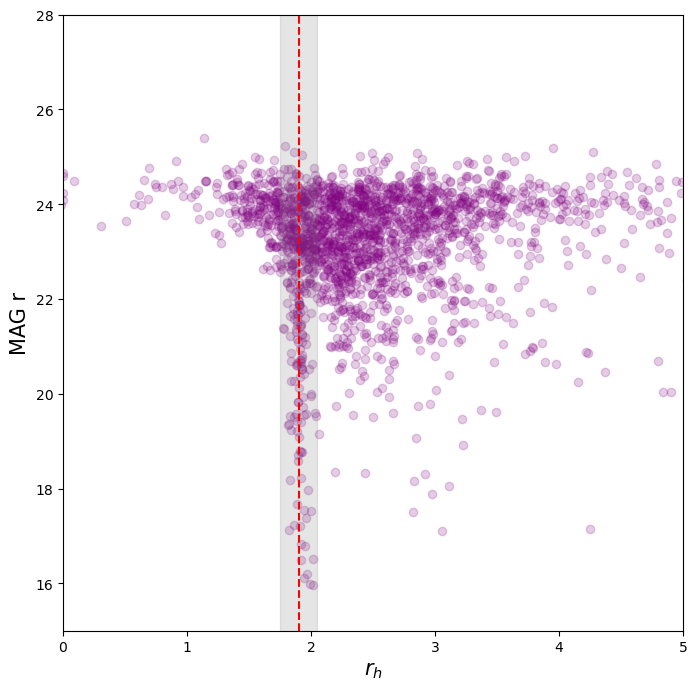

In [24]:
plt.figure(figsize = (8,8), facecolor='white')
plt.scatter(r_h, mag_aparenter , color="purple", alpha=0.2, zorder=1)
plt.xlabel("$r_h$", fontsize=15)
plt.ylabel("MAG r", fontsize=15)
plt.axvline(r, color='r', linestyle='--')
plt.fill_betweenx(np.arange(13, 30, 0.1), r - 0.15, r + 0.15, color='gray', alpha=0.2) #ngc2101 - 1.95 ESO410-018 - 1.8
plt.xlim(0, 5)
plt.ylim(15, 28)
plt.savefig(p_directory + 'halflight.png', format='png', dpi=float(10), transparent=True)

This code block calculates the colors of the found sources from previous data. One color is simply the subtraction of two different magnitudes. Each color reveals different properties about the object.

In [25]:
g_r_color = round(mag_aparenteg - mag_aparenter, 3)
g_i_color = round(mag_aparenteg - mag_aparentei, 3)
g_z_color = round(mag_aparenteg - mag_aparentez, 3)
r_z_color = round(mag_aparenter - mag_aparentez, 3)
r_i_color = round(mag_aparenter - mag_aparentei, 3)
i_z_color = round(mag_aparentei - mag_aparentez, 3)

In [26]:
Eg_r_color = (emag_aparenteg**2 + emag_aparenter**2)**(1/2)
Eg_i_color = (emag_aparenteg**2 + emag_aparentei**2)**(1/2)
Eg_z_color = (emag_aparenteg**2 + emag_aparentez**2)**(1/2)
Er_z_color = (emag_aparenter**2 + emag_aparentez**2)**(1/2)
Er_i_color = (emag_aparenter**2 + emag_aparentei**2)**(1/2)
Ei_z_color = (emag_aparentei**2 + emag_aparentez**2)**(1/2)

And here, a data frame is created from catalog data and the previously calculated colors.

In [27]:
#Define which parameters are put on the data frame
data = {
    "x-Image-g" : pd.Series(x_imageg),
    "y-Image-g" : pd.Series(y_imageg),
    "RA" : pd.Series(RA),
    "DEC" : pd.Series(DEC),
    #"class-g" : pd.Series(classg),
    #"class-r" : pd.Series(classr),
    #"class-i" : pd.Series(classi),
    #"class-z" : pd.Series(classz),
    "MAG-g" : pd.Series(mag_aparenteg),
    "MAG-r" : pd.Series(mag_aparenter),
    "MAG-i" : pd.Series(mag_aparentei),
    "MAG-z" : pd.Series(mag_aparentez),
    "aber-r" : pd.Series(mag_aberr),
    "aber-r6" : pd.Series(mag_aberr6),
    "r_h" :  pd.Series(r_h),
    "EMAG-g" : pd.Series(emag_aparenteg),
    "EMAG-r" : pd.Series(emag_aparenter),
    "EMAG-i" : pd.Series(emag_aparentei),
    "EMAG-z" : pd.Series(emag_aparentez),
    "(g-r)" : pd.Series(g_r_color),
    "(r-z)" : pd.Series(r_z_color),
    "(r-i)" : pd.Series(r_i_color),
    "(g-i)" : pd.Series(g_i_color),
    "(r-z)" : pd.Series(r_z_color),
    "(g-z)" : pd.Series(g_z_color),
    "(i-z)" : pd.Series(i_z_color),
    "E(g-r)" : pd.Series(Eg_r_color),
    "E(r-z)" : pd.Series(Er_z_color),
    "E(r-i)" : pd.Series(Er_i_color),
    "E(g-i)" : pd.Series(Eg_i_color),
    "E(r-z)" : pd.Series(Er_z_color),
    "E(g-z)" : pd.Series(Eg_z_color),
    "E(i-z)" : pd.Series(Ei_z_color),
    #"MAG_AUTO_r" : pd.Series(mag_autor),
    "e" : pd.Series(e),
    "FLUX-g" : pd.Series(flux_aparenteg),
    "FLUX-r" : pd.Series(flux_aparenter),
    "FLUX-i" : pd.Series(flux_aparentei), 
    "FLUX-z" : pd.Series(flux_aparentez),
    "E-g" : pd.Series(eflux_aparenteg),
    "E-r" : pd.Series(eflux_aparenter),
    "E-i" : pd.Series(eflux_aparentei),
    "E-z" : pd.Series(eflux_aparentez),
    #"FLUX-r" : pd.Series(flux_aparenter),
    #"FLUX-i" : pd.Series(flux_aparentei),
    #"FLUX-z" : pd.Series(flux_aparentez),
    #"x-Image-r" : pd.Series(x_imager),
    #"x-Image-i" : pd.Series(x_imagei),
    #"x-Image-z" : pd.Series(x_imagez),
    #"y-Image-r" : pd.Series(y_imager),
    #"y-Image-i" : pd.Series(y_imagei),
    #"y-Image-z" : pd.Series(y_imagez),
}

#Transform the data on a dataframe
df = pd.DataFrame(data)

#Remove data with any information null ou NaN
df = df.dropna(how="any")

df 

x-Image-g  y-Image-g         RA        DEC    MAG-g    MAG-r    MAG-i  \
0     1408.8855    29.0820  10.768216 -22.340977  24.0276  22.5534  21.9648   
1      770.9222    24.4544  10.717828 -22.341374  20.1788  19.7323  19.4514   
2      903.3075    25.1028  10.728284 -22.341316  23.8076  23.2588  23.0953   
3      326.5588    23.1452  10.682731 -22.341502  23.8988  23.0871  22.6316   
4       38.9293    22.2346  10.660013 -22.341585  22.2407  21.4505  21.2581   
...         ...        ...        ...        ...      ...      ...      ...   
2067  1013.8702  1862.9159  10.736840 -22.207045  20.2974  19.9461  19.8293   
2068  1934.9436  1974.9369  10.809504 -22.198763  24.5075  23.5771  22.5742   
2069   859.7738  1947.4275  10.724673 -22.200885  24.6934  22.9877  22.2558   
2070  1660.6903  1975.6537  10.787865 -22.198743  18.0815  16.5225  21.0673   
2071  1215.8834  1972.6613  10.752769 -22.199009  23.8973  23.7272  23.4109   

        MAG-z   aber-r  aber-r6  ...    E(i-z)      e      FLUX-g  \
0     21.5824  22.4370  23.3553  ...  0.011650  0.289    244.8808   
1     19.3863  19.6922  20.5227  ...  0.001500  0.031   8481.8030   
2     23.0694  22.9648  24.1354  ...  0.037284  0.282    299.8790   
3     22.3778  22.8285  23.9700  ...  0.022623  0.428    275.7283   
4     21.1828  21.2935  22.3055  ...  0.007824  0.028   1269.8040   
...       ...      ...      ...  ...       ...    ...         ...   
2067  19.7306  19.9436  20.6879  ...  0.002702  0.028   7604.2170   
2068  22.2451  23.6076  24.3268  ...  0.040849  0.089    157.3947   
2069  22.1700  22.8974  23.7727  ...  0.029658  0.105    132.6342   
2070  20.6635  16.5630  17.2575  ...  0.010734  0.016  58530.9600   
2071  23.4837  23.8284  24.4701  ...  0.104151  0.270    276.1063   

           FLUX-r      FLUX-i      FLUX-z        E-g        E-r       E-i  \
0        951.9962   1637.0730   2328.3840   16.16688   16.13016  14.40880   
1      12795.7300  16574.6300  17598.8100   27.88027   24.01253  17.97653   
2        497.1602    577.9366    591.9126   16.63362   16.20518  14.47826   
3        582.3174    885.8453   1119.1470   17.12480   16.80816  14.96592   
4       2629.1240   3138.6880   3364.0320   21.45170   20.82184  17.59223   
...           ...         ...         ...        ...        ...       ...   
2067   10509.2000  11702.2100  12815.9200   37.42755   31.15228  22.83784   
2068     370.8054    933.9134   1264.6120   32.75559   32.25242  28.57939   
2069     638.1649   1252.2040   1355.2300   29.10443   28.73446  25.26531   
2070  246043.1000   3741.6330   5427.4630  131.52120  164.32640  30.74647   
2071     322.9412    432.1655    404.1450   31.88608   30.71603  27.76653   

           E-z  
0     14.07816  
1     15.28717  
2     13.91692  
3     13.71649  
4     15.31309  
...        ...  
2067  20.57038  
2068  27.71695  
2069  24.96715  
2070  29.81088  
2071  28.77578  

[2072 rows x 36 columns]

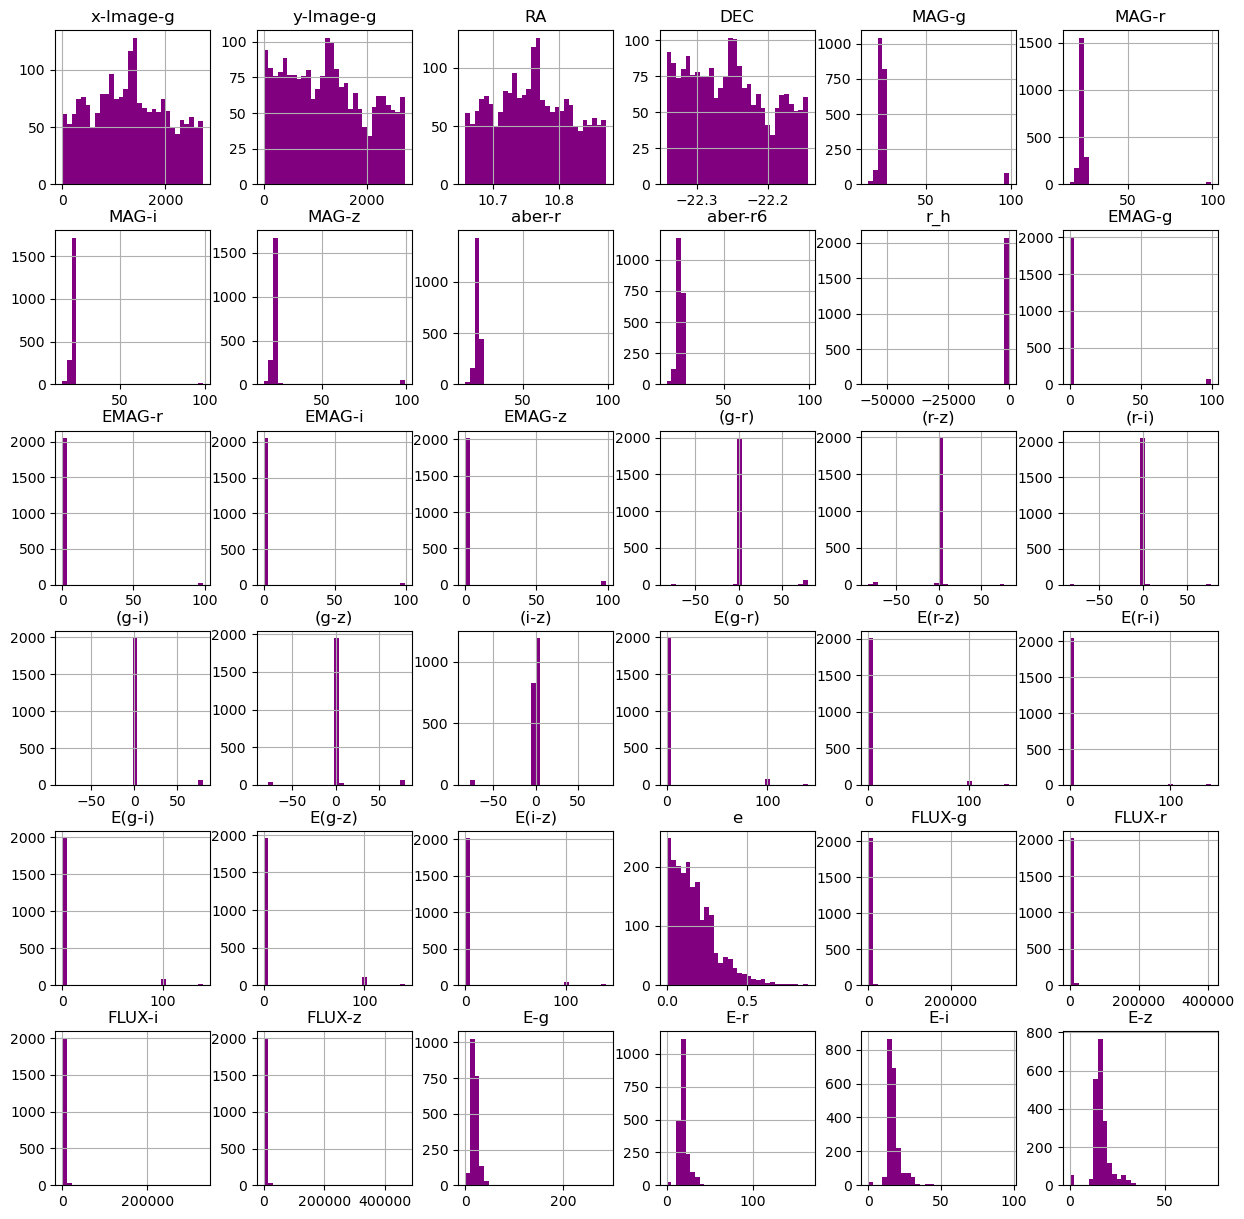

In [28]:
df.hist(color="purple", alpha=1.0, bins=30, figsize=[15,15])
plt.show()

Just like we got the sources from the mentioned catalogs, here we will obtain the **model star parameters from data defined above**. These star models are theoretical simulations of metallicity and magnitudes (to calculate color) for stars with the same age (isochrone). These models, together with observational samples (like the catalogs mentioned above), allow for the **estimation of the metallicity and age for the sources, and refine the sample, increasing the confidence for the Globular Cluster candidates**.

In [29]:
#alterar nome das variaveis
gmod1 = data135['gmag']
rmod1 = data135['rmag']
imod1 = data135['imag']
zmod1 = data135['zmag']

In [30]:
gmod2 = data10['gmag']
rmod2 = data10['rmag']
imod2 = data10['imag']
zmod2 = data10['zmag']

In [31]:
gmod3 = data9['gmag']
rmod3 = data9['rmag']
imod3 = data9['imag']
zmod3 = data9['zmag']

In [32]:
gmod4 = data6['gmag']
rmod4 = data6['rmag']
imod4 = data6['imag']
zmod4 = data6['zmag']

The models provide isochrones, which represent all the theoretical stars with the same age but with different metallicities, and consequently, different magnitudes. To begin, we will **calculate the colors in the same way as we did previously.**

In [33]:
#g-r color, and r-i color to the 13.5 Gyr population
g_r_star_model_135 = gmod1 - rmod1
g_i_star_model_135 = gmod1 - imod1
r_i_star_model_135 = rmod1 - imod1
g_z_star_model_135 = gmod1 - zmod1
i_z_star_model_135 = imod1 - zmod1
r_z_star_model_135 = rmod1 - zmod1
i_z_star_model_135 = imod1 - zmod1

#g-r color, and r-i color to the 10.0 Gyr population
g_r_star_model_10 = gmod2 - rmod2
g_i_star_model_10 = gmod2 - imod2
r_i_star_model_10 = rmod2 - imod2
g_z_star_model_10 = gmod2 - zmod2
i_z_star_model_10 = imod2 - zmod2
r_z_star_model_10 = rmod2 - zmod2
i_z_star_model_10 = imod2 - zmod2

#g-r color, and r-i color to the 9.0 Gyr population
g_r_star_model_9 = gmod3 - rmod3
g_i_star_model_9 = gmod3 - imod3
r_i_star_model_9 = rmod3 - imod3
g_z_star_model_9 = gmod3 - zmod3
i_z_star_model_9 = imod3 - zmod3
r_z_star_model_9 = rmod3 - zmod3
i_z_star_model_9 = imod3 - zmod3

#g-r color, and r-i color to the 6.0 Gyr population
g_r_star_model_6 = gmod4 - rmod4
g_i_star_model_6 = gmod4 - imod4
r_i_star_model_6 = rmod4 - imod4
g_z_star_model_6 = gmod4 - zmod4
i_z_star_model_6 = imod4 - zmod4
r_z_star_model_6 = rmod4 - zmod4
i_z_star_model_6 = imod4 - zmod4

The lowest value matches the newest population with more metallicity, while the highest value represents sources with less metallicity, therefore, with lower metallicity.

In [34]:
#The lowest value
x_lowest = g_i_star_model_6[0]
y_lowest = i_z_star_model_6[0]

#The highest value
x_highest = g_i_star_model_135[12]
y_highest = i_z_star_model_135[12]

To improve the visualization of these values, we will plot the **isochrones with their confidence region**, which represents a value fluctuation within which the sources are also considered Globular Cluster candidates.

0.5339999999999998 0.06099999999999994
1.1520000000000001 0.2030000000000003


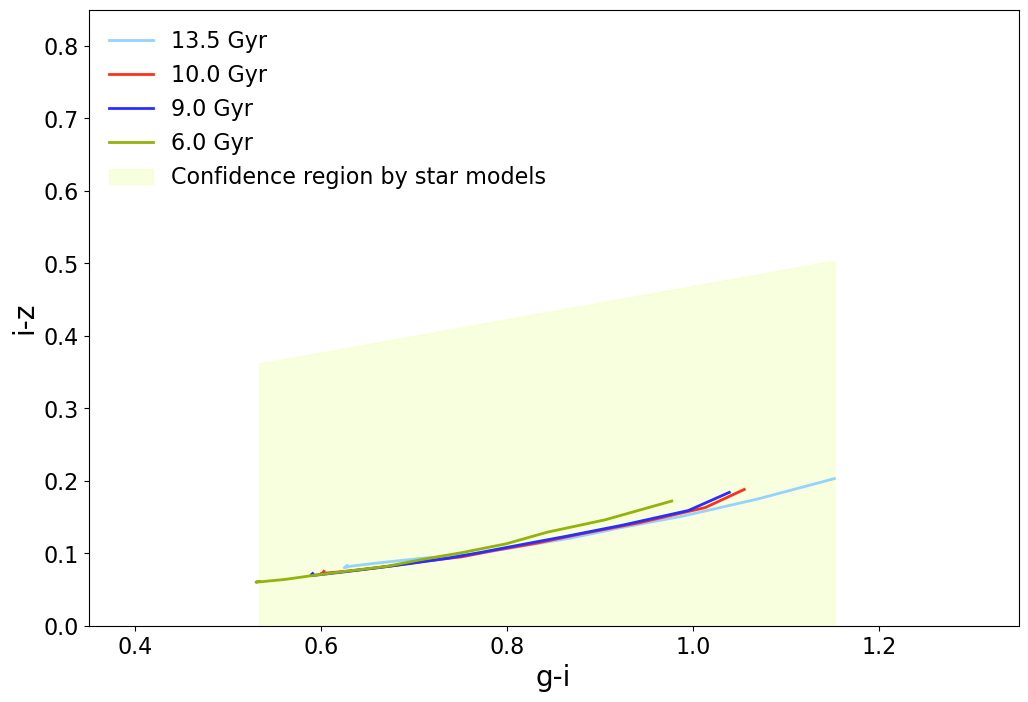

In [35]:
#Define the diagram layout
plt.figure(figsize = (12,8), facecolor='white')
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.xlabel("g-i", fontsize=20)
plt.ylabel("i-z", fontsize=20)
plt.xlim(0.35, 1.35)
plt.ylim(0, 0.85)

#Plot the isochrones, each one represents diferent ages
plt.plot(g_i_star_model_135, i_z_star_model_135, linewidth=2, color="#94D3FF", label="13.5 Gyr")  #13.5 Gyr
plt.plot(g_i_star_model_10, i_z_star_model_10, linewidth=2, color="#FF3019", label="10.0 Gyr")  #10.0 Gyr
plt.plot(g_i_star_model_9, i_z_star_model_9, linewidth=2, color="#292DFF", label="9.0 Gyr")  #9.0 Gyr
plt.plot(g_i_star_model_6, i_z_star_model_6, linewidth=2, color="#92B309", label="6.0 Gyr")  #6.0 Gyr

#This fluctuation will be defined to a "delta", in this moment we will use the 0.1 value to interval.
delta=0.3

#The confidence region is defined by this polygon where the previously defined parameters x and y 
#fluctuate with a delta up and down, generating this statistical region.
polygon1 = [[x_lowest,y_lowest-delta], [x_lowest,y_lowest+delta], [x_highest,y_highest+delta], [x_highest,y_highest-delta], [x_lowest,y_lowest-delta]]
xs, ys = zip(*polygon1) # create lists of x and y values
plt.fill(xs, ys, c="#F3FFBF", alpha=0.5, label="Confidence region by star models")
plt.legend(frameon=False, fontsize=16, loc='upper left')

print(x_lowest, y_lowest)
print(x_highest, y_highest)

plt.savefig(p_directory + 'star_models.png', format='png', dpi=float(d), transparent=True)
plt.show()

In [36]:
x_lowest2 = g_z_star_model_6[0]
y_lowest2 = r_i_star_model_6[0]

x_highest2 = g_z_star_model_135[12]
y_highest2 = r_i_star_model_135[12]

0.5949999999999998 0.1429999999999998
1.3550000000000004 0.34699999999999953


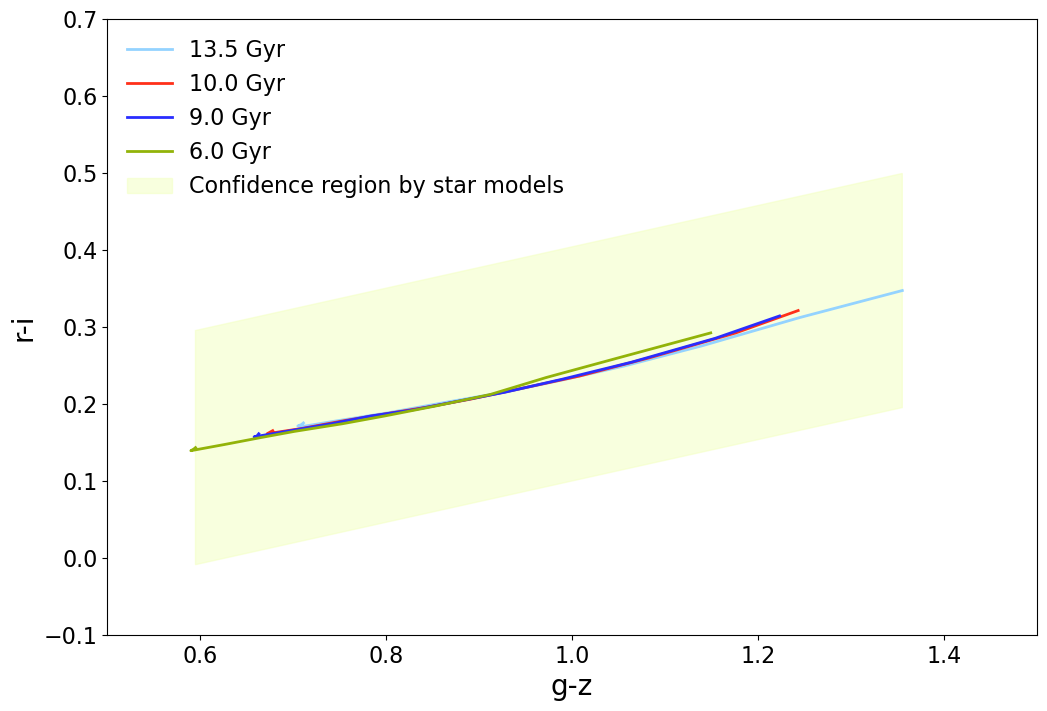

In [37]:
#Define the diagram layout
plt.figure(figsize = (12,8), facecolor='white')
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.xlabel("g-z", fontsize=20)
plt.ylabel("r-i", fontsize=20)
plt.xlim(0.5, 1.5)
plt.ylim(-0.1, 0.7)

#Plot the isochrones, each one represents diferent ages
plt.plot(g_z_star_model_135, r_i_star_model_135, linewidth=2, color="#94D3FF", label="13.5 Gyr")  #13.5 Gyr
plt.plot(g_z_star_model_10, r_i_star_model_10, linewidth=2, color="#FF3019", label="10.0 Gyr")  #10.0 Gyr
plt.plot(g_z_star_model_9, r_i_star_model_9, linewidth=2, color="#292DFF", label="9.0 Gyr")  #9.0 Gyr
plt.plot(g_z_star_model_6, r_i_star_model_6, linewidth=2, color="#92B309", label="6.0 Gyr")  #6.0 Gyr

#This fluctuation will be defined to a "delta", in this moment we will use the 0.1 value to interval.
delta=0.152025

#The confidence region is defined by this polygon where the previously defined parameters x and y 
#fluctuate with a delta up and down, generating this statistical region.
polygon2 = [[x_lowest2,y_lowest2-delta], [x_lowest2,y_lowest2+delta], [x_highest2,y_highest2+delta], [x_highest2,y_highest2-delta], [x_lowest2,y_lowest2-delta]]
xs2, ys2 = zip(*polygon2) # create lists of x and y values
plt.fill(xs2,ys2,c="#F3FFBF", alpha=0.5, label="Confidence region by star models")
plt.legend(frameon=False, fontsize=16, loc='upper left')

print(x_lowest2, y_lowest2)
print(x_highest2, y_highest2)

plt.savefig(p_directory + 'star_models.png', format='png', dpi=float(d), transparent=True)
plt.show()

Here, we can visualize all the sources on a **color-color diagram by plotting their colors on the same color system as the star model**. This plot reveals the **confidence interval and behavior of the sources**. Only the sources within the red rectangle can be considered as Globular Cluster candidates.

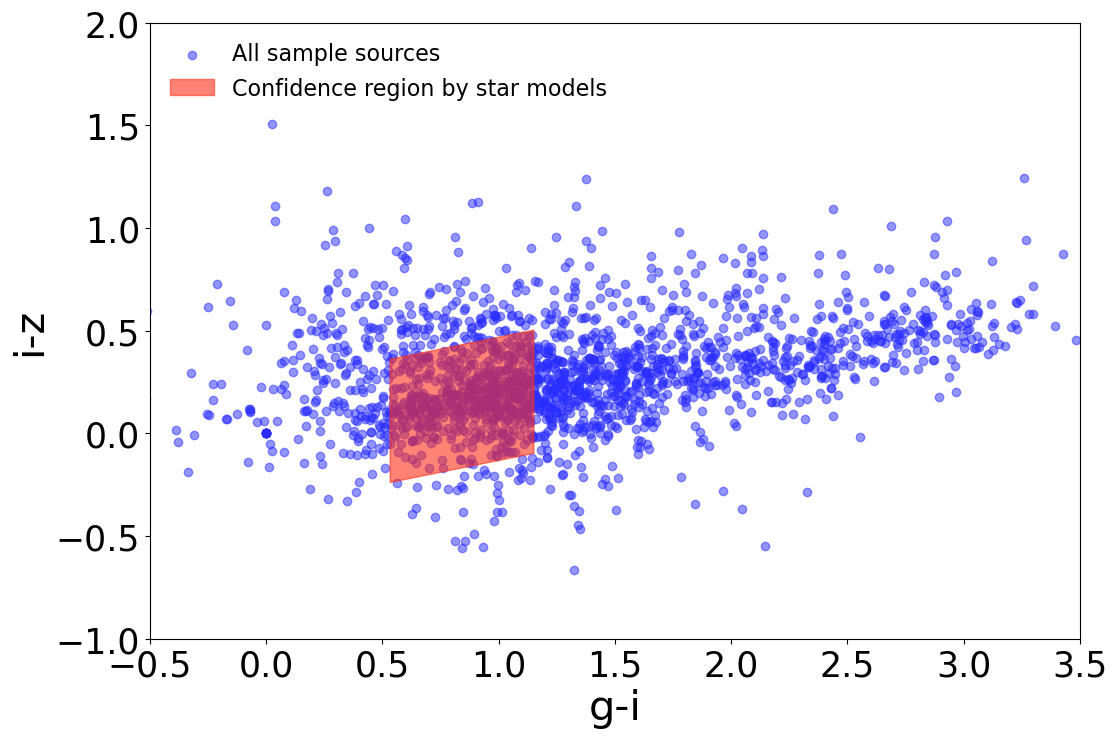

In [38]:
#Define the diagram layout
plt.figure(figsize = (12,8))
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.xlim(-0.5, 3.5)
plt.ylim(-1, 2.)
plt.xlabel("g-i", fontsize=30)
plt.ylabel("i-z", fontsize=30)

plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')

#ax = plt.gca()
#ax.spines['bottom'].set_color('white')
#ax.spines['top'].set_color('white')
#ax.spines['right'].set_color('white')
#ax.spines['left'].set_color('white')

#plt.fill([-0.5, 4, 4, -0.5], [-1.6, -1.6, 4, 4], facecolor='black', alpha=1.0, zorder=-3)
#Ṕlot the sample souces 
plt.scatter(df["(g-i)"],df["(i-z)"], color="#292DFF", alpha=0.5, zorder=0, label="All sample sources")

#Plot the confidence region 
plt.fill(xs,ys,c='#FF3019', zorder=1, alpha=0.6, label="Confidence region by star models")
plt.legend(frameon=False, fontsize=16, loc='upper left')

plt.savefig(p_directory + 'all_color_color.png', format='png', dpi=1500, transparent=True)
plt.show()

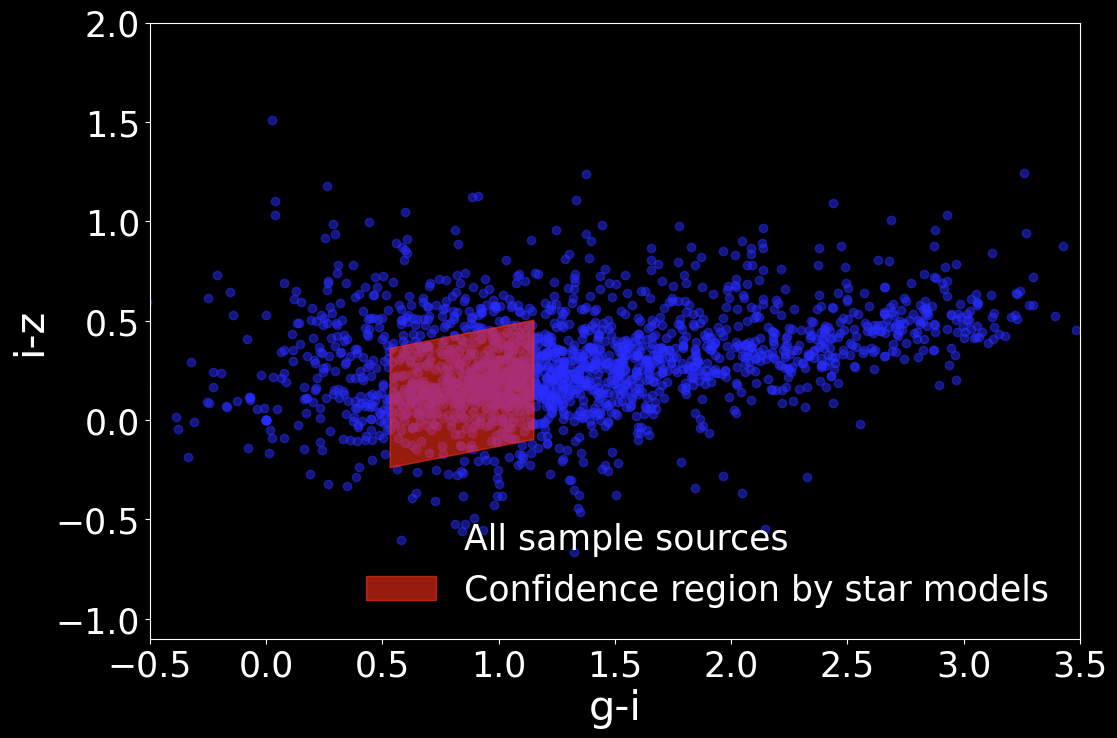

In [39]:
#Define the diagram layout
plt.figure(figsize = (12,8), facecolor='black')
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.xlim(-0.5, 3.5)
plt.ylim(-1.1, 2)
plt.xlabel("g-i", fontsize=30, color='white')
plt.ylabel("i-z", fontsize=30, color='white')

plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

ax = plt.gca()
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

plt.fill([-0.5, 4, 4, -0.5], [-1.6, -1.6, 4, 4], facecolor='black', alpha=1.0, zorder=-3)
#Ṕlot the sample souces 
plt.scatter(df["(g-i)"],df["(i-z)"], color="#292DFF", alpha=0.5, zorder=0, label="All sample sources")

#Plot the confidence region 
plt.fill(xs,ys,c='#FF3019', zorder=1, alpha=0.6, label="Confidence region by star models")
plt.legend(frameon=False, fontsize=25, loc='lower right', facecolor='black', edgecolor='white', labelcolor='white')

plt.savefig(p_directory + 'all_color_color.png', format='png', dpi=1500, transparent=True)
plt.show()

The next steps are the main purpose of this code: to cut the sample in different ways, each with a different scientific justification.

To make this cut, it is important to observe how the sources are behaving. The magnitudes of the sources contain errors, which vary depending on the image band. **After observing the background noise signal, we calculated the maximum error for the magnitude**. We noticed that some sources that were cut had an error greater than the ratio of the signal to noise. Please look to the following plot as an example:

In [40]:
#Maximum error tolerated based on background noise signal 0.2171
erro_max = (0.2171)

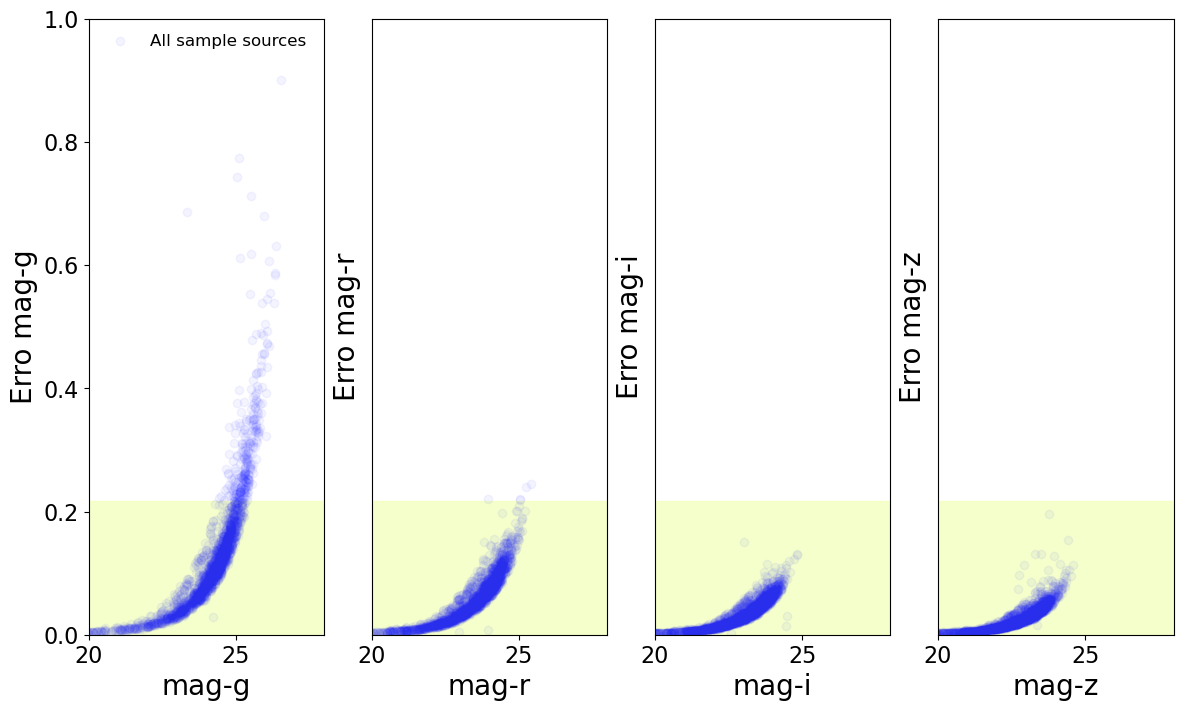

In [41]:
#Define the diagram layout
plt.figure(figsize=(14, 8), facecolor='white')
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

30#Before plotting the error diagram from the g band, we need to define the subplot layout
plt.subplot(1, 4, 1)
plt.ylim(0,1)
plt.xlim(20, 28)
plt.xlabel("mag-g", fontsize = 20)
plt.ylabel("Erro mag-g", fontsize = 20)
#Plot the no cuted catalog samples
plt.scatter(df["MAG-g"], df["EMAG-g"], color="#292DFF", alpha=0.05, zorder=1, label="All sample sources")
#Plot the yet cuted catalog samples
#plt.scatter(df_one_cut["MAG-g"], df_one_cut["EMAG-g"], color="#FF3019", alpha=0.1, zorder=2, label="Two times cut sources")
#Draw a region with the confidence magnitude error
plt.axhspan(0, erro_max, color="#F3FFBF", alpha=0.8, zorder=0)
plt.legend(frameon=False, fontsize=12,loc='upper left')

#Before plotting the error diagram from the r band, we need to define the subplot layout
plt.subplot(1, 4, 2)
plt.ylim(0,1)
plt.xlim(20, 28)
plt.yticks([])
plt.xlabel("mag-r", fontsize = 20)
plt.ylabel("Erro mag-r", fontsize = 20)
#Plot the no cuted catalog samples
plt.scatter(df["MAG-r"], df["EMAG-r"], color="#292DFF", alpha=0.05, zorder=1)
#Plot the yet cuted catalog samples
#plt.scatter(df_one_cut["MAG-r"], df_one_cut["EMAG-r"], color="#FF3019", alpha=0.1, zorder=2)
#Draw a region with the confidence magnitude error
plt.axhspan(0, erro_max, color="#F3FFBF", alpha=0.8, zorder=0)

#Before plotting the error diagram from the i band, we need to define the subplot layout
plt.subplot(1, 4, 3)
plt.ylim(0,1)
plt.xlim(20, 28)
plt.yticks([])
plt.xlabel("mag-i", fontsize = 20)
plt.ylabel("Erro mag-i", fontsize = 20)
#Plot the no cuted catalog samples
plt.scatter(df["MAG-i"], df["EMAG-i"], color="#292DFF", alpha=0.05, zorder=1)
#Plot the yet cuted catalog samples
#plt.scatter(df_one_cut["MAG-i"], df_one_cut["EMAG-i"], color="#FF3019", alpha=0.1, zorder=2)
#Draw a region with the confidence magnitude error
plt.axhspan(0, erro_max, color="#F3FFBF", alpha=0.8, zorder=0)

#Before plotting the error diagram from the z band, we need to define the subplot layout
plt.subplot(1, 4, 4)
plt.ylim(0,1)
plt.xlim(20, 28)
plt.yticks([])
plt.xlabel("mag-z", fontsize = 20)
plt.ylabel("Erro mag-z", fontsize = 20)
#Plot the no cuted catalog samples
plt.scatter(df["MAG-z"], df["EMAG-z"], color="#292DFF", alpha=0.05, zorder=1)
#Plot the yet cuted catalog samples
#plt.scatter(df_one_cut["MAG-z"], df_one_cut["EMAG-z"], color="#FF3019", alpha=0.1, zorder=2)
#Draw a region with the confidence magnitude error
plt.axhspan(0, erro_max, color="#F3FFBF", alpha=0.8, zorder=0)

plt.savefig(p_directory + 'error.png', format='png', dpi=float(d), transparent=True)
plt.show()

**1 . To improve the quality of sources in the sample of globular cluster candidates, we will remove sources with magnitude errors higher than the threshold defined by the signal-to-noise ratio.**

In [42]:
#We will limit the data frame to only include sources with magnitude errors lower than the previously
#defined threshold.
df_one_cut = df[(df["EMAG-g"] <= erro_max) &
                        (df["EMAG-r"] <= erro_max) &
                        (df["EMAG-i"] <= erro_max) &
                        (df["EMAG-z"] <= erro_max)]

#Create a new index for the data frame, as the removal of sources has broken the numerical sequence
new_index = range(0,len(df_one_cut))
df_one_cut = df_one_cut.reset_index(drop=True)
len(df)
df_one_cut

x-Image-g  y-Image-g         RA        DEC    MAG-g    MAG-r    MAG-i  \
0     1408.8855    29.0820  10.768216 -22.340977  24.0276  22.5534  21.9648   
1      770.9222    24.4544  10.717828 -22.341374  20.1788  19.7323  19.4514   
2      903.3075    25.1028  10.728284 -22.341316  23.8076  23.2588  23.0953   
3      326.5588    23.1452  10.682731 -22.341502  23.8988  23.0871  22.6316   
4       38.9293    22.2346  10.660013 -22.341585  22.2407  21.4505  21.2581   
...         ...        ...        ...        ...      ...      ...      ...   
1671  1010.5129  1992.0074  10.736562 -22.197615  24.4117  23.3289  22.8559   
1672  1931.4886  1902.3368  10.809241 -22.204067  21.3401  20.6278  20.3768   
1673  1013.8702  1862.9159  10.736840 -22.207045  20.2974  19.9461  19.8293   
1674  1660.6903  1975.6537  10.787865 -22.198743  18.0815  16.5225  21.0673   
1675  1215.8834  1972.6613  10.752769 -22.199009  23.8973  23.7272  23.4109   

        MAG-z   aber-r  aber-r6  ...    E(i-z)      e      FLUX-g  \
0     21.5824  22.4370  23.3553  ...  0.011650  0.289    244.8808   
1     19.3863  19.6922  20.5227  ...  0.001500  0.031   8481.8030   
2     23.0694  22.9648  24.1354  ...  0.037284  0.282    299.8790   
3     22.3778  22.8285  23.9700  ...  0.022623  0.428    275.7283   
4     21.1828  21.2935  22.3055  ...  0.007824  0.028   1269.8040   
...       ...      ...      ...  ...       ...    ...         ...   
1671  22.4864  23.3074  24.1241  ...  0.052951  0.112    171.9103   
1672  20.2704  20.6214  21.3656  ...  0.004686  0.025   2910.3350   
1673  19.7306  19.9436  20.6879  ...  0.002702  0.028   7604.2170   
1674  20.6635  16.5630  17.2575  ...  0.010734  0.016  58530.9600   
1675  23.4837  23.8284  24.4701  ...  0.104151  0.270    276.1063   

           FLUX-r      FLUX-i      FLUX-z        E-g        E-r       E-i  \
0        951.9962   1637.0730   2328.3840   16.16688   16.13016  14.40880   
1      12795.7300  16574.6300  17598.8100   27.88027   24.01253  17.97653   
2        497.1602    577.9366    591.9126   16.63362   16.20518  14.47826   
3        582.3174    885.8453   1119.1470   17.12480   16.80816  14.96592   
4       2629.1240   3138.6880   3364.0320   21.45170   20.82184  17.59223   
...           ...         ...         ...        ...        ...       ...   
1671     466.0528    720.5286   1012.6090   33.33959   32.71919  28.55861   
1672    5608.8330   7067.5230   7795.4200   31.93220   29.66812  23.46085   
1673   10509.2000  11702.2100  12815.9200   37.42755   31.15228  22.83784   
1674  246043.1000   3741.6330   5427.4630  131.52120  164.32640  30.74647   
1675     322.9412    432.1655    404.1450   31.88608   30.71603  27.76653   

           E-z  
0     14.07816  
1     15.28717  
2     13.91692  
3     13.71649  
4     15.31309  
...        ...  
1671  28.81209  
1672  21.48545  
1673  20.57038  
1674  29.81088  
1675  28.77578  

[1676 rows x 36 columns]

**2. Obviously, we will cut the  sources that don't are within on the confidence region**

In [43]:
#Define a mask with all souces within the confidence region
path = Path(np.column_stack([xs, ys]))
mask = path.contains_points(df_one_cut[["(g-i)", "(i-z)"]])

df_two_cut = df_one_cut.loc[mask]

new_index = range(0,len(df_two_cut))
df_two_cut = df_two_cut.reset_index(drop=True)
df_two_cut

#path = Path(np.column_stack([xs2, ys2]))
#mask = path.contains_points(df_two_cut[["(g-z)", "(r-i)"]])

#df_two_cut = df_two_cut.loc[mask]

#new_index = range(0,len(df_two_cut))
#df_two_cut = df_two_cut.reset_index(drop=True)
#estuturadf_two_cut

x-Image-g  y-Image-g         RA        DEC    MAG-g    MAG-r    MAG-i  \
0     770.9222    24.4544  10.717828 -22.341374  20.1788  19.7323  19.4514   
1     903.3075    25.1028  10.728284 -22.341316  23.8076  23.2588  23.0953   
2      38.9293    22.2346  10.660013 -22.341585  22.2407  21.4505  21.2581   
3    2129.8933    17.0470  10.825164 -22.341770  24.5613  24.0965  23.6595   
4    1133.4507    11.3701  10.746463 -22.342298  23.2484  22.6682  22.6285   
..         ...        ...        ...        ...      ...      ...      ...   
558  1403.3832  2006.2069  10.767559 -22.196539  23.3734  22.6925  22.4624   
559   234.6296  1956.3623  10.675345 -22.200277  23.7067  22.8675  22.7692   
560  1981.7124  2000.4691  10.813191 -22.196892  23.2363  22.2565  22.3364   
561  2047.1735  1994.6521  10.818357 -22.197309  23.4063  22.7030  22.7775   
562  1931.4886  1902.3368  10.809241 -22.204067  21.3401  20.6278  20.3768   

       MAG-z   aber-r  aber-r6  ...    E(i-z)      e     FLUX-g      FLUX-r  \
0    19.3863  19.6922  20.5227  ...  0.001500  0.031  8481.8030  12795.7300   
1    23.0694  22.9648  24.1354  ...  0.037284  0.282   299.8790    497.1602   
2    21.1828  21.2935  22.3055  ...  0.007824  0.028  1269.8040   2629.1240   
3    23.3886  23.8892  24.9511  ...  0.060166  0.084   149.7900    229.8225   
4    22.4610  22.2695  23.5988  ...  0.024493  0.257   501.9480    856.4843   
..       ...      ...      ...  ...       ...    ...        ...         ...   
558  22.2484  22.5649  23.4878  ...  0.038311  0.280   447.3554    837.5333   
559  22.4355  22.7589  23.7027  ...  0.047871  0.211   329.0984    712.8787   
560  22.3308  21.9259  23.1967  ...  0.037411  0.248   507.5345   1251.3850   
561  22.8162  22.5309  23.5540  ...  0.058407  0.187   433.9882    829.4554   
562  20.2704  20.6214  21.3656  ...  0.004686  0.025  2910.3350   5608.8330   

         FLUX-i      FLUX-z       E-g       E-r       E-i       E-z  
0    16574.6300  17598.8100  27.88027  24.01253  17.97653  15.28717  
1      577.9366    591.9126  16.63362  16.20518  14.47826  13.91692  
2     3138.6880   3364.0320  21.45170  20.82184  17.59223  15.31309  
3      343.7247    441.1170  16.92891  16.23948  15.06295  14.96071  
4      888.3840   1036.5270  18.12542  17.38691  15.36003  14.93924  
..          ...         ...       ...       ...       ...       ...  
558   1035.2840   1260.8230  33.91422  32.88937  28.34577  28.14709  
559    780.4048   1061.2500  33.39640  31.96256  27.93553  27.22755  
560   1162.5760   1168.6720  34.32326  33.81029  28.79757  27.93127  
561    774.4739    747.3393  35.06043  34.06263  29.38542  28.49288  
562   7067.5230   7795.4200  31.93220  29.66812  23.46085  21.48545  

[563 rows x 36 columns]

In [44]:
#path = Path(np.column_stack([xs2, ys2]))

**3. Now we cut the sample using the elipcticity param, to remove the sources with no geometrical compatibility**

In [45]:
df_three_cut = df_two_cut[(df_two_cut["e"] <= 10.) & (df_two_cut["e"] >= -10)]

new_index = range(0,len(df_three_cut))
df_three_cut = df_three_cut.reset_index(drop=True)

df_three_cut

x-Image-g  y-Image-g         RA        DEC    MAG-g    MAG-r    MAG-i  \
0     770.9222    24.4544  10.717828 -22.341374  20.1788  19.7323  19.4514   
1     903.3075    25.1028  10.728284 -22.341316  23.8076  23.2588  23.0953   
2      38.9293    22.2346  10.660013 -22.341585  22.2407  21.4505  21.2581   
3    2129.8933    17.0470  10.825164 -22.341770  24.5613  24.0965  23.6595   
4    1133.4507    11.3701  10.746463 -22.342298  23.2484  22.6682  22.6285   
..         ...        ...        ...        ...      ...      ...      ...   
558  1403.3832  2006.2069  10.767559 -22.196539  23.3734  22.6925  22.4624   
559   234.6296  1956.3623  10.675345 -22.200277  23.7067  22.8675  22.7692   
560  1981.7124  2000.4691  10.813191 -22.196892  23.2363  22.2565  22.3364   
561  2047.1735  1994.6521  10.818357 -22.197309  23.4063  22.7030  22.7775   
562  1931.4886  1902.3368  10.809241 -22.204067  21.3401  20.6278  20.3768   

       MAG-z   aber-r  aber-r6  ...    E(i-z)      e     FLUX-g      FLUX-r  \
0    19.3863  19.6922  20.5227  ...  0.001500  0.031  8481.8030  12795.7300   
1    23.0694  22.9648  24.1354  ...  0.037284  0.282   299.8790    497.1602   
2    21.1828  21.2935  22.3055  ...  0.007824  0.028  1269.8040   2629.1240   
3    23.3886  23.8892  24.9511  ...  0.060166  0.084   149.7900    229.8225   
4    22.4610  22.2695  23.5988  ...  0.024493  0.257   501.9480    856.4843   
..       ...      ...      ...  ...       ...    ...        ...         ...   
558  22.2484  22.5649  23.4878  ...  0.038311  0.280   447.3554    837.5333   
559  22.4355  22.7589  23.7027  ...  0.047871  0.211   329.0984    712.8787   
560  22.3308  21.9259  23.1967  ...  0.037411  0.248   507.5345   1251.3850   
561  22.8162  22.5309  23.5540  ...  0.058407  0.187   433.9882    829.4554   
562  20.2704  20.6214  21.3656  ...  0.004686  0.025  2910.3350   5608.8330   

         FLUX-i      FLUX-z       E-g       E-r       E-i       E-z  
0    16574.6300  17598.8100  27.88027  24.01253  17.97653  15.28717  
1      577.9366    591.9126  16.63362  16.20518  14.47826  13.91692  
2     3138.6880   3364.0320  21.45170  20.82184  17.59223  15.31309  
3      343.7247    441.1170  16.92891  16.23948  15.06295  14.96071  
4      888.3840   1036.5270  18.12542  17.38691  15.36003  14.93924  
..          ...         ...       ...       ...       ...       ...  
558   1035.2840   1260.8230  33.91422  32.88937  28.34577  28.14709  
559    780.4048   1061.2500  33.39640  31.96256  27.93553  27.22755  
560   1162.5760   1168.6720  34.32326  33.81029  28.79757  27.93127  
561    774.4739    747.3393  35.06043  34.06263  29.38542  28.49288  
562   7067.5230   7795.4200  31.93220  29.66812  23.46085  21.48545  

[563 rows x 36 columns]

**4. The concentration param also will be used**

In [46]:
df_four_cut = df_three_cut[(df_three_cut["r_h"] <= r+0.1) & (df_three_cut["r_h"] >= r-0.1)]

new_index = range(0,len(df_four_cut))
df_four_cut = df_four_cut.reset_index(drop=True)   

df_four_cut

x-Image-g  y-Image-g         RA        DEC    MAG-g    MAG-r    MAG-i  \
0   1607.9042    11.1502  10.783937 -22.342265  22.3062  21.7313  21.4158   
1   1424.9750    66.5389  10.769482 -22.338239  24.3680  24.2297  23.6345   
2   1173.3835    72.7040  10.749611 -22.337814  23.7821  23.0707  22.8548   
3   2275.6426    77.8184  10.836667 -22.337311  23.2135  22.6225  22.5116   
4    932.1232    92.8853  10.730554 -22.336361  24.8557  24.0598  23.7184   
..        ...        ...        ...        ...      ...      ...      ...   
72   379.3256  2241.3452  10.686742 -22.179448  23.6572  23.2978  22.6817   
73  1855.6886  1782.2262  10.803276 -22.212851  22.4493  22.0550  21.9029   
74   370.5130  2159.5559  10.686053 -22.185424  23.5671  23.0751  22.9382   
75  1385.1244  2107.0730  10.766107 -22.189173  23.4332  22.8418  22.8086   
76   824.0374  2057.8887  10.721843 -22.192818  17.8414  17.2127  17.1185   

      MAG-z   aber-r  aber-r6  ...    E(i-z)      e      FLUX-g       FLUX-r  \
0   21.3741  21.7345  22.4589  ...  0.008705  0.013   1195.4110    2029.8360   
1   23.4788  24.2227  25.0659  ...  0.058007  0.125    178.9828     203.2997   
2   22.6245  22.9596  23.9111  ...  0.025567  0.265    307.0089     591.1964   
3   22.3705  22.6505  23.3381  ...  0.019925  0.052    518.3141     893.3021   
4   23.3554  24.0058  24.8240  ...  0.058920  0.081    114.2168     237.7235   
..      ...      ...      ...  ...       ...    ...         ...          ...   
72  22.6201  23.2582  24.0445  ...  0.028160  0.112    344.4497     479.6102   
73  21.6856  22.0772  22.7646  ...  0.012884  0.034   1047.7810    1506.5810   
74  22.7054  23.0982  23.7666  ...  0.039215  0.017    374.2519     588.7690   
75  22.6562  22.8684  23.5879  ...  0.038354  0.068    423.3752     729.9241   
76  17.1376  17.2569  17.9464  ...  0.000640  0.021  73022.2300  130295.1000   

         FLUX-i       FLUX-z        E-g        E-r       E-i       E-z  
0     2714.5620    2820.7730   19.42163   18.28943  15.88281  15.28803  
1      351.7308     405.9445   16.22964   15.67435  14.24805  14.11731  
2      721.2684     891.6514   15.29331   14.90469  13.35701  12.98072  
3      989.3715    1126.6560   16.10280   15.25988  13.79621  13.45362  
4      325.5639     454.8347   16.45085   15.92693  14.50286  14.06319  
..          ...          ...        ...        ...       ...       ...  
72     845.9126     895.3018   19.29065   18.13395  16.00748  15.79653  
73    1733.2000    2117.1670   20.39509   19.08108  16.19086  15.64326  
74     667.8895     827.6222   22.79269   21.53746  18.85238  18.61110  
75     752.6193     866.0195   24.30795   23.36153  20.13010  20.04476  
76  142107.0000  139621.2000  136.74760  117.19680  68.75923  47.61190  

[77 rows x 36 columns]

**5. Using the GAIA dr3 let's remove the star contamination**

In [47]:
match = []
indexes_to_drop = []
tolerance = 0.0001

v = Vizier(catalog='I/355')
v.ROW_LIMIT = 1000000000000000 #### Aumentar o limite de número de fontes
result = v.query_region(cord, radius=40*u.arcmin)

x = np.array(result['I/355/gaiadr3']["RA_ICRS"])
y = np.array(result['I/355/gaiadr3']["DE_ICRS"])
x = [round(num, 6) for num in result['I/355/gaiadr3']["RA_ICRS"]]
y = [round(num, 6) for num in result['I/355/gaiadr3']["DE_ICRS"]]

for a in tqdm(range(0, len(df_four_cut))):
    for b in range(0, len(x)):
        if(math.isclose(df_four_cut['RA'][a], x[b], rel_tol=tolerance) & math.isclose(df_four_cut['DEC'][a], y[b], rel_tol=tolerance)):
            #print(df_five_cut['RA'][a], x[b])
            match.append([df_four_cut['RA'][a], df_four_cut['DEC'][a]])
            #print(df_five_cut['DEC'][a], y[b])
            #print("--")
            indexes_to_drop.append(a)

df_four_cut = df_four_cut.drop(indexes_to_drop)
df_four_cut = df_four_cut.reset_index(drop=True)
df_four_cut

100%|███████████████████████████████████████████| 77/77 [00:01<00:00, 48.96it/s]


x-Image-g  y-Image-g         RA        DEC    MAG-g    MAG-r    MAG-i  \
0   1607.9042    11.1502  10.783937 -22.342265  22.3062  21.7313  21.4158   
1   1424.9750    66.5389  10.769482 -22.338239  24.3680  24.2297  23.6345   
2   2275.6426    77.8184  10.836667 -22.337311  23.2135  22.6225  22.5116   
3     60.9145   207.8555  10.661739 -22.328024  23.0541  22.7149  22.4069   
4    807.1837   233.6944  10.720674 -22.326085  24.5048  24.1856  23.4538   
5   1170.7426   293.5642  10.749379 -22.321679  22.5825  21.9810  21.8303   
6    403.1134   304.0984  10.688757 -22.320972  23.6682  23.4405  22.8778   
7   2159.0381   311.0808  10.827424 -22.320286  23.4936  23.0275  22.8411   
8    218.1458   323.7030  10.674149 -22.319551  22.9975  22.3476  21.8882   
9   1725.3733   337.4469  10.793174 -22.318414  23.7539  23.0235  22.8620   
10  2268.6252   353.7659  10.836072 -22.317153  23.0945  22.4755  22.3024   
11    67.4729   484.5287  10.662241 -22.307811  24.6269  24.3679  24.0667   
12  1337.1118   493.3901  10.762496 -22.307064  24.8473  24.2865  23.9162   
13   599.7280   527.7272  10.704266 -22.304621  22.0309  21.3716  21.2024   
14   954.0901   538.9393  10.732247 -22.303773  23.2102  22.4049  22.4606   
15    47.9548   546.5105  10.660696 -22.303284  24.2392  23.7281  23.3467   
16   333.7658   563.5509  10.683263 -22.302022  23.8170  23.2352  22.9403   
17  1425.5031   566.9491  10.769467 -22.301682  24.4751  24.1436  23.5526   
18   921.0646   581.8249  10.729635 -22.300643  24.5087  24.1117  23.3801   
19  1338.0732   580.9781  10.762562 -22.300666  24.4603  23.8259  23.8387   
20   489.0185   598.5933  10.695519 -22.299452  24.5712  24.1460  23.5391   
21   703.4092   608.5422  10.712447 -22.298709  23.7843  23.2272  23.0853   
22  1243.5771   626.9800  10.755096 -22.297315  23.7158  23.0050  22.8176   
23    13.9450   621.1755  10.658006 -22.297831  24.4254  23.8840  23.6673   
24  2291.5869   662.9320  10.837839 -22.294564  23.7235  23.1249  22.8873   
25  2045.5175   737.4716  10.818400 -22.289151  24.4734  24.1062  23.6578   
26  2276.3032   758.8025  10.836618 -22.287562  23.9713  23.3002  22.9405   
27  2280.4714   768.7300  10.836946 -22.286836  24.0819  23.2971  23.2219   
28   393.3693   783.6650  10.687954 -22.285938  22.9397  22.3351  22.2388   
29  2529.7859   827.4185  10.856620 -22.282513  24.2302  23.5920  23.2994   
30  2394.7612   879.6885  10.845952 -22.278714  24.0710  23.4560  23.3076   
31  1343.3022   921.8672  10.762938 -22.275762  23.9017  23.0736  22.7593   
32  1632.1603   948.8820  10.785739 -22.273757  23.8051  23.2165  23.0733   
33   333.8191  1063.1080  10.683233 -22.265527  23.8631  23.3915  23.0541   
34  1303.2295  1066.1462  10.759759 -22.265226  24.0471  23.6472  23.2672   
35  1185.5624  1142.9830  10.750462 -22.259624  23.1168  22.5472  22.4612   
36   544.6776  1262.7115  10.699863 -22.250931  24.4211  23.8130  23.3137   
37   905.2197  1360.3207  10.728312 -22.243772  22.2197  21.8195  21.6853   
38  1172.9099  1359.9149  10.749441 -22.243777  23.6548  23.5402  22.9952   
39   258.7350  1369.1130  10.677286 -22.243177  24.4507  23.9385  23.7837   
40  2249.0122  1376.8467  10.834373 -22.242415  24.5055  23.7812  23.3731   
41  1229.7629  1435.5624  10.753920 -22.238245  22.9511  22.3568  22.2251   
42   480.2752  2723.1499  10.694671 -22.144243  24.2058  23.4699  23.0944   
43   648.9918  2701.3374  10.707980 -22.145824  23.3991  23.1054  22.8468   
44  1698.7828  2643.7769  10.790788 -22.149929  22.7325  22.2454  22.1138   
45  1781.1986  2623.5261  10.797291 -22.151399  21.8077  21.4228  21.2653   
46  1908.4696  2612.8813  10.807331 -22.152161  23.0748  22.6349  22.4320   
47   773.4789  2550.7471  10.717811 -22.156816  24.4453  23.9358  23.7617   
48  1350.7865  1662.7723  10.763447 -22.221634  24.1413  23.2287  23.0203   
49  2070.9998  1641.5114  10.820286 -22.223104  24.4124  24.3736  23.7923   
50   433.4984  1561.0011  10.691066 -22.229147  24.6691  24.1186  23.9872   


**5. This cut is a little bit most complicated. We select the sources are within the region of 8x effectiver radius** 

In [48]:
#7.305555555556000E-05

cd = math.radians(7.305e-5) #graus

raio = (float(effective_radius)/ 3600) #graus
#tamanho_angular_pix = math.sin(cd) * (float(dis)* 10**6) #pc de um pixel
#tamanho_angular_raio = math.sin(raio) * (float(dis)* 10**6)	86.600708, -52.088528

q_pix = raio  / 7.305e-5

x_ = float(x_pix)
y_ = float(y_pix)
raio_corte = 5*q_pix
center = float(np.array(galaxy_params[galaxy_params["nome"] == galaxy_name]["centerx"])[-1])
center_y = float(np.array(galaxy_params[galaxy_params["nome"] == galaxy_name]["centery"])[-1])
max_ratio = center + raio_corte
min_ratio = center - raio_corte
(raio*60)*10

8.738333333333333

In [49]:
df_five_cut = df_four_cut
df_five_cut['x-Image-g'] = df_four_cut['x-Image-g'][(df_four_cut['x-Image-g'] - center)**2 + (df_four_cut['y-Image-g'] - center_y)**2 <= raio_corte**2]

df_five_cut  = df_five_cut.dropna()
new_index = range(0,len(df_five_cut))
df_five_cut = df_five_cut.reset_index(drop=True)


df_five_cut.to_csv('ESO410_018_GC_candidates_iniciais.csv', index=False)
df_five_cut

x-Image-g  y-Image-g         RA        DEC    MAG-g    MAG-r    MAG-i  \
0   1337.1118   493.3901  10.762496 -22.307064  24.8473  24.2865  23.9162   
1    954.0901   538.9393  10.732247 -22.303773  23.2102  22.4049  22.4606   
2   1425.5031   566.9491  10.769467 -22.301682  24.4751  24.1436  23.5526   
3    921.0646   581.8249  10.729635 -22.300643  24.5087  24.1117  23.3801   
4   1338.0732   580.9781  10.762562 -22.300666  24.4603  23.8259  23.8387   
5   1243.5771   626.9800  10.755096 -22.297315  23.7158  23.0050  22.8176   
6   2045.5175   737.4716  10.818400 -22.289151  24.4734  24.1062  23.6578   
7   1343.3022   921.8672  10.762938 -22.275762  23.9017  23.0736  22.7593   
8   1632.1603   948.8820  10.785739 -22.273757  23.8051  23.2165  23.0733   
9   1303.2295  1066.1462  10.759759 -22.265226  24.0471  23.6472  23.2672   
10  1185.5624  1142.9830  10.750462 -22.259624  23.1168  22.5472  22.4612   
11   544.6776  1262.7115  10.699863 -22.250931  24.4211  23.8130  23.3137   
12   905.2197  1360.3207  10.728312 -22.243772  22.2197  21.8195  21.6853   
13  1172.9099  1359.9149  10.749441 -22.243777  23.6548  23.5402  22.9952   
14  2249.0122  1376.8467  10.834373 -22.242415  24.5055  23.7812  23.3731   
15  1229.7629  1435.5624  10.753920 -22.238245  22.9511  22.3568  22.2251   
16  1350.7865  1662.7723  10.763447 -22.221634  24.1413  23.2287  23.0203   
17  2070.9998  1641.5114  10.820286 -22.223104  24.4124  24.3736  23.7923   
18   433.4984  1561.0011  10.691066 -22.229147  24.6691  24.1186  23.9872   
19  1500.7631  1547.5620  10.775296 -22.230035  23.6876  23.1259  22.7152   
20  1029.6261  2270.8789  10.738043 -22.177240  24.3429  23.6192  23.1971   
21  1855.6886  1782.2262  10.803276 -22.212851  22.4493  22.0550  21.9029   
22  1385.1244  2107.0730  10.766107 -22.189173  23.4332  22.8418  22.8086   

      MAG-z   aber-r  aber-r6  ...    E(i-z)      e     FLUX-g     FLUX-r  \
0   23.7541  24.1904  25.1535  ...  0.069398  0.213   115.0960   192.9217   
1   22.1907  22.3638  23.1458  ...  0.017140  0.040   519.8790  1091.5620   
2   23.2877  23.9193  25.0639  ...  0.061105  0.229   162.1642   220.0792   
3   23.0859  23.9877  24.9085  ...  0.041621  0.188   157.2181   226.6353   
4   23.6794  23.8687  24.5629  ...  0.076264  0.006   164.3892   294.8789   
5   22.6954  22.8985  23.8375  ...  0.029482  0.152   326.3424   628.0363   
6   23.5460  24.0409  24.7674  ...  0.069991  0.022   162.4228   227.7780   
7   22.5063  23.0300  23.8106  ...  0.027224  0.016   274.9897   589.5808   
8   23.0399  23.1136  23.9598  ...  0.042228  0.084   300.5901   516.9087   
9   23.0894  23.4370  24.5372  ...  0.052111  0.184   240.5271   347.6365   
10  22.4296  22.3336  23.4259  ...  0.028083  0.079   566.6136   957.4703   
11  22.9857  23.6939  24.6161  ...  0.039292  0.203   170.4396   298.3991   
12  21.5811  21.8509  22.5421  ...  0.009849  0.017  1294.5300  1871.5660   
13  22.8005  23.4356  24.3076  ...  0.031831  0.087   345.1985   383.6285   
14  23.1264  23.7723  24.5338  ...  0.059264  0.183   157.6871   307.2805   
15  22.1195  22.3850  23.0651  ...  0.017498  0.010   660.0513  1140.9450   
16  22.8815  23.1321  24.0180  ...  0.039906  0.050   220.5315   511.1267   
17  23.6693  24.3429  25.2134  ...  0.087353  0.368   171.8122   178.0645   
18  23.8447  24.0989  24.7886  ...  0.112668  0.262   135.6314   225.1870   
19  22.5418  23.0900  23.8816  ...  0.031305  0.047   334.9385   561.8785   
20  23.2207  23.6580  24.3183  ...  0.047451  0.150   183.1615   356.7076   
21  21.6856  22.0772  22.7646  ...  0.012884  0.034  1047.7810  1506.5810   
22  22.6562  22.8684  23.5879  ...  0.038354  0.068   423.3752   729.9241   

       FLUX-i     FLUX-z       E-g       E-r       E-i       E-z  
0    271.3469   315.0296  14.59977  14.32952  13.24052  13.00631  
1   1036.9500  1329.5410  15.48362  15.13836  13.06428  12.61446  
2    379.2935   484.0768  19.25896  18.75512  16.90159  16.63039  
3    444.5756   582.9673  15.73441  15

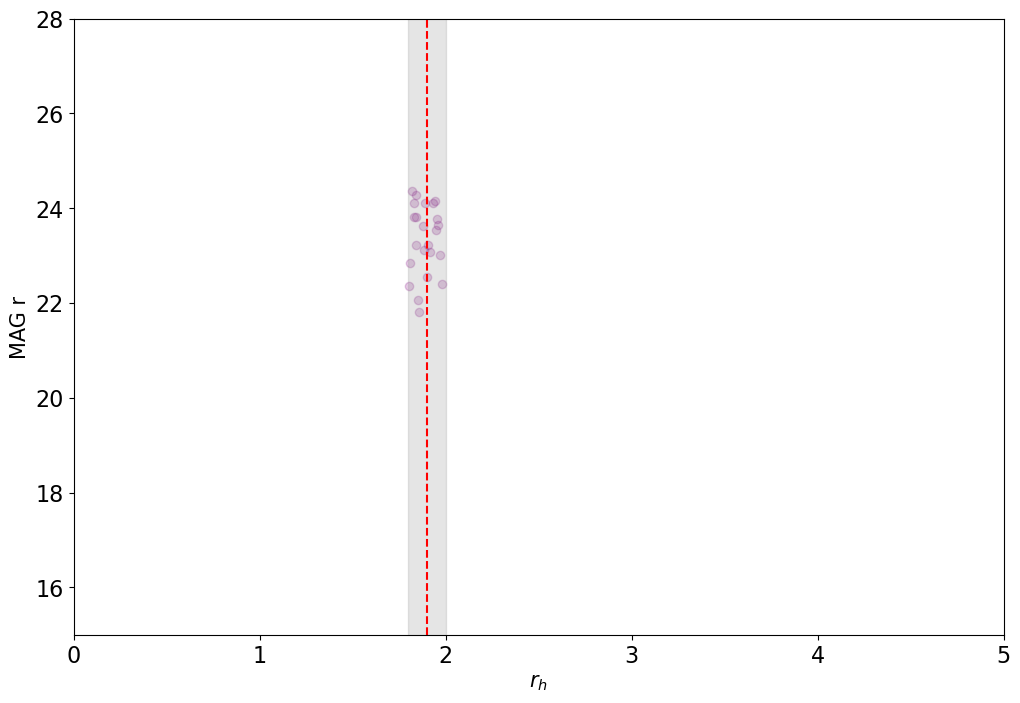

In [50]:
plt.figure(figsize = (12,8), facecolor='white')
plt.scatter(df_five_cut['r_h'], df_five_cut['MAG-r'] , color="purple", alpha=0.2, zorder=1)
plt.xlabel("$r_h$", fontsize=15)
plt.ylabel("MAG r", fontsize=15)
plt.axvline(r, color='r', linestyle='--')
plt.fill_betweenx(np.arange(13, 30, 0.1), r - 0.1, r + 0.1, color='gray', alpha=0.2) #ngc2101 - 1.95 ESO410-018 - 1.8
plt.xlim(0, 5)
plt.ylim(15, 28)
plt.savefig(p_directory + 'halflight.png', format='png', dpi=float(10), transparent=True)

**IR photometry**

In [51]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils.aperture import SkyCircularAperture
from astropy.wcs import WCS
from photutils.aperture import aperture_photometry
from astropy.table import Table
from photutils.background import Background2D, MedianBackground
from astropy.stats import SigmaClip
from photutils.utils import calc_total_error

img_3_6 = fits.open(IR_input_directory + "/" + galaxy_name + "_3.6.fits")[0]
img_4_5 = fits.open(IR_input_directory + "/" + galaxy_name + "_4.5.fits")[0]

image_3_6 = img_3_6.data.astype(float)
image_4_5 = img_4_5.data.astype(float)

positions = SkyCoord(df_five_cut["RA"] * u.deg, df_five_cut["DEC"] * u.deg, unit=[u.deg, u.deg])
aperture = SkyCircularAperture(positions, r=2. * u.arcsec)

sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()

bkg_3_6 = Background2D(image_3_6, (50, 50), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
bkg_4_5 = Background2D(image_4_5, (50, 50), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)


wcs_3_6 = WCS(img_3_6.header)  
wcs_4_5 = WCS(img_4_5.header)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

In [52]:
data_3_6 = u.Quantity(img_3_6.data, unit=img_3_6.header['BUNIT'])
bkg_3_6_ = u.Quantity(bkg_3_6.background, unit=img_3_6.header['BUNIT'])

phot_table_3_6 = aperture_photometry(data_3_6 - bkg_3_6_, aperture, wcs=wcs_3_6)
phot_table_np_3_6 = np.array(phot_table_3_6)
mask_3_6 = np.isnan(phot_table_3_6['aperture_sum'])
#phot_table_3_6.remove_rows(mask_3_6)
flux_mjy_sr_3_6 = phot_table_3_6["aperture_sum"]
factor = (1.32*10**(-5))*(u.sr)
flux_jy_3_6 = (flux_mjy_sr_3_6 * factor)

phot_table_3_6 = Table(phot_table_3_6, copy=True)
phot_table_3_6['id'] = range(len(phot_table_3_6))
phot_table_3_6["aperture_sum"] = flux_jy_3_6
phot_table_3_6

<Table length=23>
  id       xcenter       ...       sky_center             aperture_sum     
             pix         ...        deg,deg                   MJy          
int64      float64       ...        SkyCoord                float64        
----- ------------------ ... ---------------------- -----------------------
    0  674.5114369885035 ... 10.7624959,-22.3070645  1.5629664521199263e-05
    1  812.5233649874801 ... 10.7322468,-22.3037733                     nan
    2  642.9562886354215 ... 10.7694673,-22.3016815 -3.0420748649817234e-06
    3  824.2821144056527 ... 10.7296351,-22.3006432                     nan
    4   674.178479949637 ... 10.7625622,-22.3006657  -1.959257362335475e-09
    5  707.9137794392743 ... 10.7550959,-22.2973146  2.3220734444622195e-06
    6 422.54563665762237 ... 10.8184001,-22.2891513                     nan
    7  672.4220097583412 ... 10.7629377,-22.2757617  2.6193363947021282e-06
    8  570.6376943005994 ...  10.7857386,-22.273757   1.075562942817234e-06
  ...                ... ...                    ...                     ...
   14 353.32163495019614 ... 10.8343727,-22.2424153                     nan
   15  712.5007521532838 ... 10.7539202,-22.2382453  -4.257494413972956e-07
   16  670.0732456281175 ...  10.763447,-22.2216344  -5.034936425762488e-07
   17  417.0385969559173 ... 10.8202859,-22.2231041                     nan
   18  999.9724991969656 ... 10.6910656,-22.2291472                     nan
   19  617.5128038427866 ... 10.7752959,-22.2300353  3.2450844685490057e-06
   20   784.767428668367 ... 10.7380434,-22.1772401                     nan
   21 492.93273358895965 ...  10.803276,-22.2128512                     nan
   22  657.9823908952548 ... 10.7661073,-22.1891726                     nan

In [53]:
data_4_5 = u.Quantity(img_4_5.data, unit=img_4_5.header['BUNIT'])
bkg_4_5 = u.Quantity(bkg_4_5.background, unit=img_4_5.header['BUNIT'])

phot_table_4_5 = aperture_photometry(data_4_5 - bkg_4_5, aperture, wcs=wcs_4_5)
phot_table_np_4_5 = np.array(phot_table_4_5)
mask_4_5 = np.isnan(phot_table_4_5['aperture_sum'])
#phot_table_4_5.remove_rows(mask_4_5)
flux_mjy_sr_4_5 = phot_table_4_5["aperture_sum"]
factor = (1.32*10**(-5))*(u.sr)
flux_jy_4_5 = (flux_mjy_sr_4_5 * factor)

phot_table_4_5 = Table(phot_table_4_5, copy=True)
phot_table_4_5['id'] = range(len(phot_table_4_5))
phot_table_4_5["aperture_sum"] = flux_jy_4_5
phot_table_4_5

<Table length=23>
  id       xcenter       ...       sky_center             aperture_sum     
             pix         ...        deg,deg                   MJy          
int64      float64       ...        SkyCoord                float64        
----- ------------------ ... ---------------------- -----------------------
    0 321.65356692892726 ... 10.7624959,-22.3070645                     nan
    1  459.4383637587417 ... 10.7322468,-22.3037733                     nan
    2  289.9642432217098 ... 10.7694673,-22.3016815                     nan
    3  471.0722119326195 ... 10.7296351,-22.3006432                     nan
    4  321.3071159535862 ... 10.7625622,-22.3006657 -3.4469696398320917e-07
    5  355.0661506500956 ... 10.7550959,-22.2973146   1.375921353491304e-06
    6  65.93500227931219 ... 10.8184001,-22.2891513                     nan
    7 319.47511400845843 ... 10.7629377,-22.2757617  3.0295444006494647e-06
    8  217.1860630495753 ...  10.7857386,-22.273757  1.2758284088408855e-06
  ...                ... ...                    ...                     ...
   14 -5.266912523803543 ... 10.8343727,-22.2424153                     nan
   15  359.3720260552702 ... 10.7539202,-22.2382453  1.9174332787456651e-07
   16  317.1151130016145 ...  10.763447,-22.2216344 -1.3019281415588832e-06
   17  60.88616146030614 ... 10.8202859,-22.2231041                     nan
   18  643.1992993883334 ... 10.6910656,-22.2291472                     nan
   19  264.4788070483554 ... 10.7752959,-22.2300353   -3.35131798832056e-07
   20 431.59658839862914 ... 10.7380434,-22.1772401 -2.3627189937390486e-06
   21 138.69393198737967 ...  10.803276,-22.2128512                     nan
   22  305.3623325107696 ... 10.7661073,-22.1891726   1.644596591496434e-06

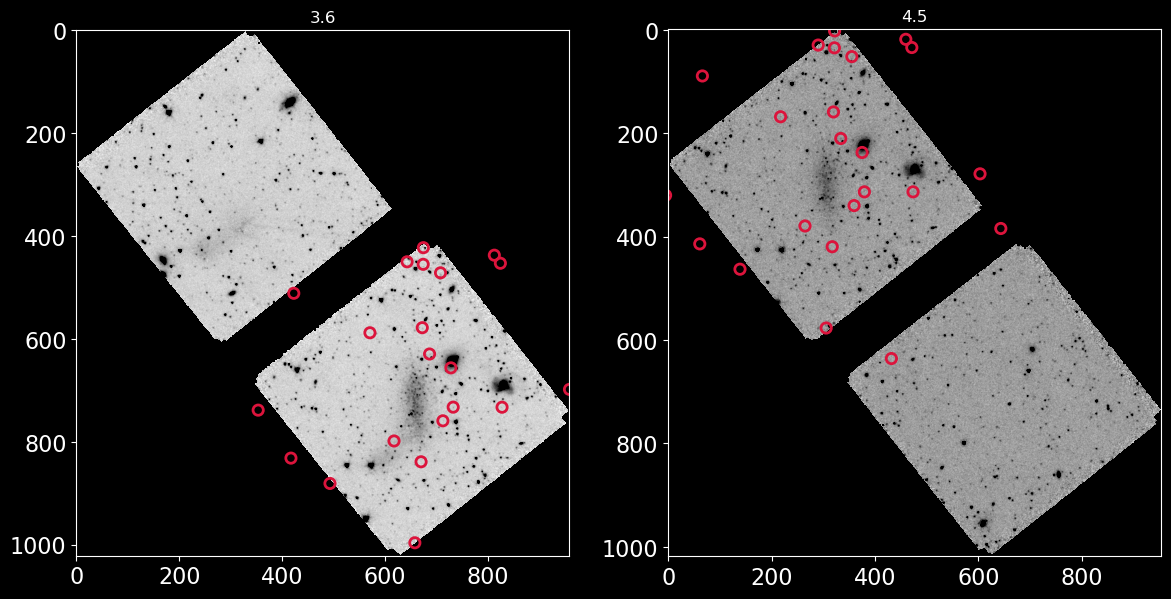

In [54]:
fig, (ax1, ax2) = plt.subplots(figsize=[14,14], facecolor="black", ncols=2)
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
ax1.spines['bottom'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.xaxis.label.set_color('white')
ax1.yaxis.label.set_color('white')
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')

ax2.spines['bottom'].set_color('white')
ax2.spines['top'].set_color('white')
ax2.spines['left'].set_color('white')
ax2.spines['right'].set_color('white')
ax2.xaxis.label.set_color('white')
ax2.yaxis.label.set_color('white')
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')

# Define o fundo dos subplots como preto
ax1.set_facecolor('black')
ax2.set_facecolor('black')

plt.subplot(1, 2, 1)
plt.title("3.6", color="white")
plt.imshow(image_3_6, cmap='gray_r',vmin=0, vmax=0.2)
for i in range(0, len(phot_table_np_3_6["xcenter"])):
    circulo = Circle((phot_table_np_3_6["xcenter"][i], phot_table_np_3_6["ycenter"][i]), radius=10, edgecolor='crimson', facecolor='none', zorder=1, linewidth=2)
    ax1.add_patch(circulo)

plt.subplot(1, 2, 2)
plt.title("4.5", color="white")
plt.imshow(image_4_5, cmap='gray_r',vmin=0.0, vmax=0.2)
for i in range(0, len(phot_table_np_4_5["xcenter"])):
    circulo = Circle((phot_table_np_4_5["xcenter"][i], phot_table_np_4_5["ycenter"][i]), radius=10, edgecolor='crimson', facecolor='none', zorder=1, linewidth=2)
    ax2.add_patch(circulo)

plt.savefig(p_directory + 'IR_image.png', format='png', dpi=700, transparent=True)
plt.show()

In [55]:
mag_3_6 = -2.5 * np.log10(phot_table_3_6["aperture_sum"]) + 8.9
mag_4_5 = -2.5 * np.log10(phot_table_4_5["aperture_sum"]) + 8.9


phot_table = phot_table_3_6
phot_table.rename_column('aperture_sum', 'Flux_3.6')

phot_table["Flux_4.5"] = phot_table_4_5["aperture_sum"]

phot_table["mag_4.5"] = mag_4_5
phot_table["mag_3.6"] = mag_3_6


phot_table

/tmp/ipykernel_11281/1157881697.py:1: RuntimeWarning: invalid value encountered in log10
  mag_3_6 = -2.5 * np.log10(phot_table_3_6["aperture_sum"]) + 8.9
/tmp/ipykernel_11281/1157881697.py:2: RuntimeWarning: invalid value encountered in log10
  mag_4_5 = -2.5 * np.log10(phot_table_4_5["aperture_sum"]) + 8.9


<Table length=23>
  id       xcenter       ...      mag_4.5            mag_3.6      
             pix         ...        MJy                MJy        
int64      float64       ...      float64            float64      
----- ------------------ ... ------------------ ------------------
    0  674.5114369885035 ...                nan  20.91512585919957
    1  812.5233649874801 ...                nan                nan
    2  642.9562886354215 ...                nan                nan
    3  824.2821144056527 ...                nan                nan
    4   674.178479949637 ...                nan                nan
    5  707.9137794392743 ... 23.553515973247066  22.98531012038655
    6 422.54563665762237 ...                nan                nan
    7  672.4220097583412 ...  22.69655669537881 22.854521806646723
    8  570.6376943005994 ...  23.63551932913244 23.820910423167284
  ...                ... ...                ...                ...
   14 353.32163495019614 ...                nan                nan
   15  712.5007521532838 ... 25.693199348338887                nan
   16  670.0732456281175 ...                nan                nan
   17  417.0385969559173 ...                nan                nan
   18  999.9724991969656 ...                nan                nan
   19  617.5128038427866 ...                nan  22.62193498541228
   20   784.767428668367 ...                nan                nan
   21 492.93273358895965 ...                nan                nan
   22  657.9823908952548 ... 23.359851535429016                nan

In [56]:
_3_6_4_5 = mag_3_6 - mag_4_5

df_five_cut["3.6 - 4.5"] = _3_6_4_5
df_five_cut["3.6"] = mag_3_6
df_five_cut["4.5"] = mag_4_5 
df_five_cut["FLUX-3.6"] = phot_table["Flux_4.5"]
df_five_cut["FLUX-4.5"] = phot_table["Flux_3.6"]

df_five_cut

x-Image-g  y-Image-g         RA        DEC    MAG-g    MAG-r    MAG-i  \
0   1337.1118   493.3901  10.762496 -22.307064  24.8473  24.2865  23.9162   
1    954.0901   538.9393  10.732247 -22.303773  23.2102  22.4049  22.4606   
2   1425.5031   566.9491  10.769467 -22.301682  24.4751  24.1436  23.5526   
3    921.0646   581.8249  10.729635 -22.300643  24.5087  24.1117  23.3801   
4   1338.0732   580.9781  10.762562 -22.300666  24.4603  23.8259  23.8387   
5   1243.5771   626.9800  10.755096 -22.297315  23.7158  23.0050  22.8176   
6   2045.5175   737.4716  10.818400 -22.289151  24.4734  24.1062  23.6578   
7   1343.3022   921.8672  10.762938 -22.275762  23.9017  23.0736  22.7593   
8   1632.1603   948.8820  10.785739 -22.273757  23.8051  23.2165  23.0733   
9   1303.2295  1066.1462  10.759759 -22.265226  24.0471  23.6472  23.2672   
10  1185.5624  1142.9830  10.750462 -22.259624  23.1168  22.5472  22.4612   
11   544.6776  1262.7115  10.699863 -22.250931  24.4211  23.8130  23.3137   
12   905.2197  1360.3207  10.728312 -22.243772  22.2197  21.8195  21.6853   
13  1172.9099  1359.9149  10.749441 -22.243777  23.6548  23.5402  22.9952   
14  2249.0122  1376.8467  10.834373 -22.242415  24.5055  23.7812  23.3731   
15  1229.7629  1435.5624  10.753920 -22.238245  22.9511  22.3568  22.2251   
16  1350.7865  1662.7723  10.763447 -22.221634  24.1413  23.2287  23.0203   
17  2070.9998  1641.5114  10.820286 -22.223104  24.4124  24.3736  23.7923   
18   433.4984  1561.0011  10.691066 -22.229147  24.6691  24.1186  23.9872   
19  1500.7631  1547.5620  10.775296 -22.230035  23.6876  23.1259  22.7152   
20  1029.6261  2270.8789  10.738043 -22.177240  24.3429  23.6192  23.1971   
21  1855.6886  1782.2262  10.803276 -22.212851  22.4493  22.0550  21.9029   
22  1385.1244  2107.0730  10.766107 -22.189173  23.4332  22.8418  22.8086   

      MAG-z   aber-r  aber-r6  ...     FLUX-z       E-g       E-r       E-i  \
0   23.7541  24.1904  25.1535  ...   315.0296  14.59977  14.32952  13.24052   
1   22.1907  22.3638  23.1458  ...  1329.5410  15.48362  15.13836  13.06428   
2   23.2877  23.9193  25.0639  ...   484.0768  19.25896  18.75512  16.90159   
3   23.0859  23.9877  24.9085  ...   582.9673  15.73441  15.33124  13.70052   
4   23.6794  23.8687  24.5629  ...   337.4628  17.71599  17.30133  15.43431   
5   22.6954  22.8985  23.8375  ...   835.2653  17.79029  17.31309  15.25557   
6   23.5460  24.0409  24.7674  ...   381.5952  18.32488  17.85289  16.60897   
7   22.5063  23.0300  23.8106  ...   994.2480  18.04577  17.75149  15.61600   
8   23.0399  23.1136  23.9598  ...   608.1729  19.29747  18.75723  16.60099   
9   23.0894  23.4370  24.5372  ...   581.0831  21.08540  20.49236  18.15377   
10  22.4296  22.3336  23.4259  ...  1066.9780  23.38328  22.52293  19.43221   
11  22.9857  23.6939  24.6161  ...   639.3350  16.22841  15.76069  13.92676   
12  21.5811  21.8509  22.5421  ...  2331.0890  18.55202  17.22289  14.44909   
13  22.8005  23.4356  24.3076  ...   758.2279  16.96192  16.25605  14.34279   
14  23.1264  23.7723  24.5338  ...   561.6392  22.10337  21.66088  19.37383   
15  22.1195  22.3850  23.0651  ...  1419.7290  18.78712  18.08773  15.49916   
16  22.8815  23.1321  24.0180  ...   703.7056  20.01750  19.62677  17.18752   
17  23.6693  24.3429  25.2134  ...   340.6218  19.67051  19.28773  18.09636   
18  23.8447  24.0989  24.7886  ...   289.8131  18.64453  18.08323  16.29250   
19  22.5418  23.0900  23.8816  ...   962.2198  21.23322  20.64063  18.09071   
20  23.2207  23.6580  24.3183  ...   514.8788  18.93100  18.32277  16.05588   
21  21.6856  22.0772  22.7646  ...  2117.1670  20.39509  19.08108  16.19086   
22  22.6562  22.8684  23.5879  ...   866.0195  24.30795  23.36153  20.13010   

         E-z  3.6 - 4.5        3.6        4.5      FLUX-3.6      FLUX-4.5  
0   13.00631        NaN  20.915126        NaN           NaN  1.562966e-05  
1   12.61446        NaN        NaN        NaN           NaN           NaN  
2   16.63039        NaN       

In [57]:
data135_IR = pd.read_csv(star_directory + '135_IR.dat', sep='\s+')
data6_IR = pd.read_csv(star_directory + '6_IR.dat', sep='\s+')

_135_4_5 = data135_IR["IRAC_4.5mag"]
_135_3_6 = data135_IR["IRAC_3.6mag"]

_6_4_5 = data6_IR["IRAC_4.5mag"]
_6_3_6 = data6_IR["IRAC_3.6mag"]
data135_IR

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_11281/2698335477.py:1: SyntaxWarning: invalid escape sequence '\s'
  data135_IR = pd.read_csv(star_directory + '135_IR.dat', sep='\s+')
/tmp/ipykernel_11281/2698335477.py:2: SyntaxWarning: invalid escape sequence '\s'
  data6_IR = pd.read_csv(star_directory + '6_IR.dat', sep='\s+')


age        Z  mbolmag  IRAC_3.6mag  IRAC_4.5mag  IRAC_5.8mag  \
0  1.350000e+10  0.00016    4.827        4.272        4.273        4.252   
1  1.350000e+10  0.00025    4.777        4.224        4.232        4.210   
2  1.350000e+10  0.00039    4.820        4.183        4.198        4.174   
3  1.350000e+10  0.00062    6.173        4.200        4.222        4.196   
4  1.350000e+10  0.00098    6.199        4.155        4.185        4.157   
5  1.350000e+10  0.00155    6.243        4.122        4.160        4.129   
6  1.350000e+10  0.00244    6.264        4.067        4.114        4.078   
7  1.350000e+10  0.00385    6.293        4.009        4.067        4.025   
8  1.350000e+10  0.00605    6.376        3.989        4.060        4.008   
9  1.350000e+10  0.00947    6.427        3.939        4.025        3.962   

   IRAC_8.0mag  MIPS_24mag  MIPS_70mag  MIPS_160mag  
0        4.227       3.922       1.269       -1.963  
1        4.179       3.890       0.954       -2.347  
2        4.137       3.864       0.695       -2.645  
3        4.156       3.882       0.634       -2.726  
4        4.111       3.838       0.442       -2.934  
5        4.078       3.799       0.323       -3.061  
6        4.024       3.742       0.201       -3.188  
7        3.968       3.679       0.095       -3.296  
8        3.948       3.652       0.014       -3.381  
9        3.899       3.592      -0.082       -3.480

In [58]:
min_size = min(len(gmod1), len(_135_4_5))
gmod1 = np.resize(gmod1, min_size)
_135_4_5 = np.resize(_135_4_5, min_size)
gmod4 = np.resize(gmod4, min_size)
_6_4_5 = np.resize(_6_4_5, min_size)
_135_3_6 = np.resize(_135_3_6, min_size)
_6_3_6 = np.resize(_6_3_6, min_size)
g_r_star_model_135 = np.resize(g_r_star_model_135, min_size)
g_r_star_model_6 = np.resize(g_r_star_model_6, min_size)


_4_5_3_6_color135 = _135_3_6 - _135_4_5
_4_5_3_6_color6 = _6_3_6 - _6_4_5

delta=0.35

#The lowest value
x_lowest = _4_5_3_6_color6[0] + 0.35
y_lowest = g_r_star_model_6[0]

#The highest value
x_highest = _4_5_3_6_color135[-1] - 0.35
y_highest = g_r_star_model_135[-1]

polygon3 = [[x_lowest,y_lowest-delta], [x_lowest,y_lowest+delta], [x_highest,y_highest+delta], [x_highest,y_highest-delta], [x_lowest,y_lowest-delta]]
xs3, ys3 = zip(*polygon3) # create lists of x and y values
df_five_cut

x-Image-g  y-Image-g         RA        DEC    MAG-g    MAG-r    MAG-i  \
0   1337.1118   493.3901  10.762496 -22.307064  24.8473  24.2865  23.9162   
1    954.0901   538.9393  10.732247 -22.303773  23.2102  22.4049  22.4606   
2   1425.5031   566.9491  10.769467 -22.301682  24.4751  24.1436  23.5526   
3    921.0646   581.8249  10.729635 -22.300643  24.5087  24.1117  23.3801   
4   1338.0732   580.9781  10.762562 -22.300666  24.4603  23.8259  23.8387   
5   1243.5771   626.9800  10.755096 -22.297315  23.7158  23.0050  22.8176   
6   2045.5175   737.4716  10.818400 -22.289151  24.4734  24.1062  23.6578   
7   1343.3022   921.8672  10.762938 -22.275762  23.9017  23.0736  22.7593   
8   1632.1603   948.8820  10.785739 -22.273757  23.8051  23.2165  23.0733   
9   1303.2295  1066.1462  10.759759 -22.265226  24.0471  23.6472  23.2672   
10  1185.5624  1142.9830  10.750462 -22.259624  23.1168  22.5472  22.4612   
11   544.6776  1262.7115  10.699863 -22.250931  24.4211  23.8130  23.3137   
12   905.2197  1360.3207  10.728312 -22.243772  22.2197  21.8195  21.6853   
13  1172.9099  1359.9149  10.749441 -22.243777  23.6548  23.5402  22.9952   
14  2249.0122  1376.8467  10.834373 -22.242415  24.5055  23.7812  23.3731   
15  1229.7629  1435.5624  10.753920 -22.238245  22.9511  22.3568  22.2251   
16  1350.7865  1662.7723  10.763447 -22.221634  24.1413  23.2287  23.0203   
17  2070.9998  1641.5114  10.820286 -22.223104  24.4124  24.3736  23.7923   
18   433.4984  1561.0011  10.691066 -22.229147  24.6691  24.1186  23.9872   
19  1500.7631  1547.5620  10.775296 -22.230035  23.6876  23.1259  22.7152   
20  1029.6261  2270.8789  10.738043 -22.177240  24.3429  23.6192  23.1971   
21  1855.6886  1782.2262  10.803276 -22.212851  22.4493  22.0550  21.9029   
22  1385.1244  2107.0730  10.766107 -22.189173  23.4332  22.8418  22.8086   

      MAG-z   aber-r  aber-r6  ...     FLUX-z       E-g       E-r       E-i  \
0   23.7541  24.1904  25.1535  ...   315.0296  14.59977  14.32952  13.24052   
1   22.1907  22.3638  23.1458  ...  1329.5410  15.48362  15.13836  13.06428   
2   23.2877  23.9193  25.0639  ...   484.0768  19.25896  18.75512  16.90159   
3   23.0859  23.9877  24.9085  ...   582.9673  15.73441  15.33124  13.70052   
4   23.6794  23.8687  24.5629  ...   337.4628  17.71599  17.30133  15.43431   
5   22.6954  22.8985  23.8375  ...   835.2653  17.79029  17.31309  15.25557   
6   23.5460  24.0409  24.7674  ...   381.5952  18.32488  17.85289  16.60897   
7   22.5063  23.0300  23.8106  ...   994.2480  18.04577  17.75149  15.61600   
8   23.0399  23.1136  23.9598  ...   608.1729  19.29747  18.75723  16.60099   
9   23.0894  23.4370  24.5372  ...   581.0831  21.08540  20.49236  18.15377   
10  22.4296  22.3336  23.4259  ...  1066.9780  23.38328  22.52293  19.43221   
11  22.9857  23.6939  24.6161  ...   639.3350  16.22841  15.76069  13.92676   
12  21.5811  21.8509  22.5421  ...  2331.0890  18.55202  17.22289  14.44909   
13  22.8005  23.4356  24.3076  ...   758.2279  16.96192  16.25605  14.34279   
14  23.1264  23.7723  24.5338  ...   561.6392  22.10337  21.66088  19.37383   
15  22.1195  22.3850  23.0651  ...  1419.7290  18.78712  18.08773  15.49916   
16  22.8815  23.1321  24.0180  ...   703.7056  20.01750  19.62677  17.18752   
17  23.6693  24.3429  25.2134  ...   340.6218  19.67051  19.28773  18.09636   
18  23.8447  24.0989  24.7886  ...   289.8131  18.64453  18.08323  16.29250   
19  22.5418  23.0900  23.8816  ...   962.2198  21.23322  20.64063  18.09071   
20  23.2207  23.6580  24.3183  ...   514.8788  18.93100  18.32277  16.05588   
21  21.6856  22.0772  22.7646  ...  2117.1670  20.39509  19.08108  16.19086   
22  22.6562  22.8684  23.5879  ...   866.0195  24.30795  23.36153  20.13010   

         E-z  3.6 - 4.5        3.6        4.5      FLUX-3.6      FLUX-4.5  
0   13.00631        NaN  20.915126        NaN           NaN  1.562966e-05  
1   12.61446        NaN        NaN        NaN           NaN           NaN  
2   16.63039        NaN       

In [59]:
#path = Path(np.column_stack([xs3, ys3]))
#mask = path.contains_points(df_five_cut[["3.6 - 4.5", "(g-z)"]])
#df_five_cut = df_five_cut.loc[mask]

#df_five_cut  = df_five_cut.dropna()
#new_index = range(0,len(df_five_cut))
#df_five_cut = df_five_cut.reset_index(drop=True)

#df_five_cut

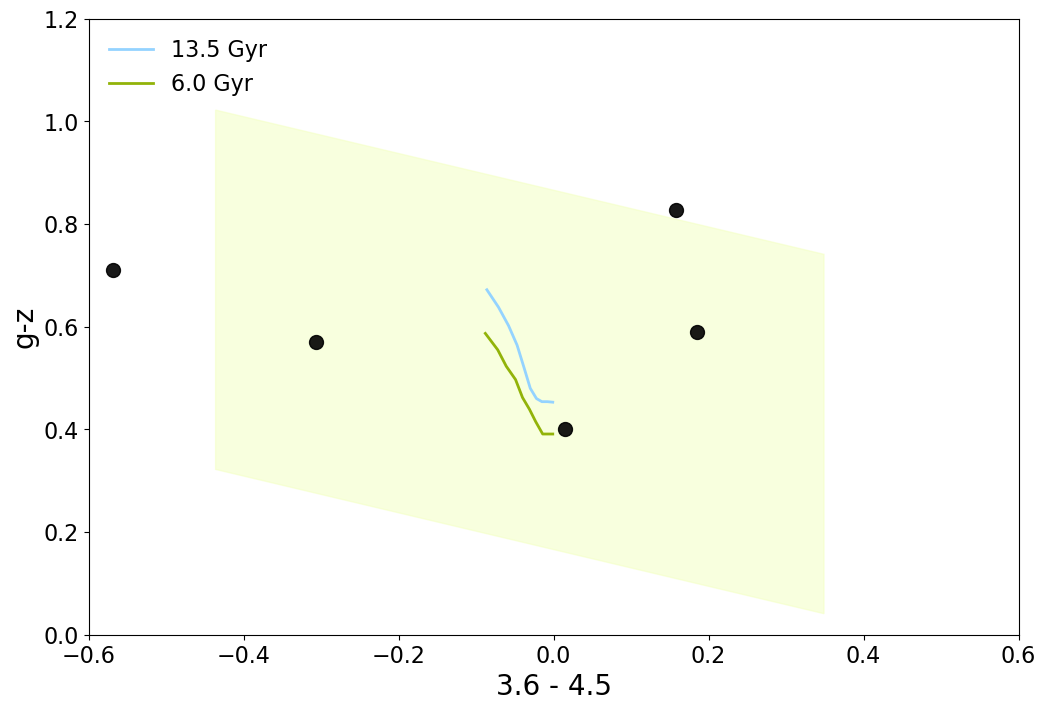

In [60]:
#Define the diagram layout
plt.figure(figsize = (12,8), facecolor='white')
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.xlabel("3.6 - 4.5", fontsize=20)
plt.ylabel("g-z", fontsize=20)
plt.xlim(-0.6, 0.6)
plt.ylim(0, 1.2)

#Plot the isochrones, each one represents diferent ages
plt.plot(_4_5_3_6_color135, g_r_star_model_135, linewidth=2, color="#94D3FF", label="13.5 Gyr")  #13.5 Gyr
plt.plot(_4_5_3_6_color6 ,g_r_star_model_6, linewidth=2, color="#92B309", label="6.0 Gyr")  #6.0 Gyr

#This fluctuation will be defined to a "delta", in this moment we will use the 0.1 value to interval.


#erro_IR = ((df_five_cut["E3.6"]**2) + (df_five_cut["E4.5"]**2))**(1/2)

#The confidence region is defined by this polygon where the previously defined parameters x and y 
#fluctuate with a delta up and down, generating this statistical region.

plt.legend(frameon=False, fontsize=16, loc='upper left')

plt.scatter(df_five_cut["3.6 - 4.5"], df_five_cut["(g-r)"], color="black", alpha=0.9, zorder = 3, label="Globular Cluster candidates", s=100)
#plt.errorbar(df_five_cut["3.6 - 4.5"], df_five_cut["(g-z)"], yerr=df_five_cut["E(g-z)"],fmt='o', capsize=5, color="black")

plt.fill(xs3,ys3,c="#F3FFBF", alpha=0.5, label="Confidence region by star models")
plt.savefig(p_directory + 'star_models.png', format='png', dpi=1200, transparent=True)
plt.show()

####

**UV photometry**

In [61]:
img_nuv = fits.open("/home/raimundo/Documentos/UFRJ/IC/Imagens_GC/" + galaxy_name + "/UV/" + galaxy_name + "_NUV.fits")[0]
img_fuv = fits.open("/home/raimundo/Documentos/UFRJ/IC/Imagens_GC/" + galaxy_name + "/UV/" + galaxy_name + "_FUV.fits")[0]

image_nuv = img_nuv.data.astype(float)
image_fuv = img_fuv.data.astype(float)

positions = SkyCoord(df_five_cut["RA"] * u.deg, df_five_cut["DEC"] * u.deg, unit=[u.deg, u.deg])
aperture_nuv = SkyCircularAperture(positions, r=8 * u.arcsec) #PSF - 4.5 FUV, 6.0 NUV
aperture_fuv = SkyCircularAperture(positions, r= 10* u.arcsec)

sigma_clip = SigmaClip(sigma=8.0)
bkg_estimator = MedianBackground()

bkg_nuv = Background2D(image_nuv, (20, 20), filter_size=(9, 9), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
bkg_fuv = Background2D(image_fuv, (20, 20), filter_size=(9, 9), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)


wcs_nuv = WCS(img_nuv.header)  
wcs_fuv = WCS(img_fuv.header)

In [62]:
data_nuv = u.Quantity(img_nuv.data, unit=img_nuv.header['BUNIT'])
bkg_nuv = u.Quantity(bkg_nuv.background, unit=img_nuv.header['BUNIT'])

phot_table_nuv = aperture_photometry(data_nuv - bkg_nuv, aperture_nuv, wcs=wcs_nuv)
phot_table_np_nuv = np.array(phot_table_nuv)
mask_nuv = np.isnan(phot_table_nuv['aperture_sum'])
#phot_table_3_6.remove_rows(mask_3_6)
flux_mjy_sr_nuv = phot_table_nuv["aperture_sum"]
flux_jy_nuv = flux_mjy_sr_nuv 

phot_table_nuv = Table(phot_table_nuv, copy=True)
phot_table_nuv['id'] = range(len(phot_table_nuv))
phot_table_nuv["aperture_sum"] = flux_jy_nuv
phot_table_nuv

<Table length=23>
  id       xcenter       ...       sky_center            aperture_sum    
             pix         ...        deg,deg                              
int64      float64       ...        SkyCoord               float64       
----- ------------------ ... ---------------------- ---------------------
    0 1336.6412136771542 ... 10.7624959,-22.3070645  0.014403238973901084
    1 1403.7951508358412 ... 10.7322468,-22.3037733  0.046871256279893976
    2 1321.1383767153734 ... 10.7694673,-22.3016815   0.06224707636224316
    3  1409.582867205324 ... 10.7296351,-22.3006432  0.017100289301471172
    4 1336.4670642767135 ... 10.7625622,-22.3006657 -0.014745374377464742
    5 1353.0325896637032 ... 10.7550959,-22.2973146   0.03325659252249453
    6  1212.417387631832 ... 10.8184001,-22.2891513  0.004057437360525372
    7  1335.528272920096 ... 10.7629377,-22.2757617  0.042763389322243064
    8 1284.8795391106407 ...  10.7857386,-22.273757  0.030353122034041138
  ...                ... ...                    ...                   ...
   14 1176.6957546265658 ... 10.8343727,-22.2424153  0.010010891344586345
   15 1355.4028862205018 ... 10.7539202,-22.2382453  0.046306359511751015
   16  1334.168541680781 ...  10.763447,-22.2216344  0.018773187934100016
   17  1207.890377618266 ... 10.8202859,-22.2231041   0.02242774030587351
   18 1495.0085967446337 ... 10.6910656,-22.2291472 -0.029939995624623218
   19  1307.879596104042 ... 10.7752959,-22.2300353    0.0385595783193335
   20  1390.441002180523 ... 10.7380434,-22.1772401 -0.006072360018312845
   21 1245.6331412151594 ...  10.803276,-22.2128512 0.0009268173064597041
   22 1328.1193729092302 ... 10.7661073,-22.1891726   0.07024812759870301

In [63]:
data_fuv = u.Quantity(img_fuv.data, unit=img_fuv.header['BUNIT'])
bkg_fuv = u.Quantity(bkg_fuv.background, unit=img_fuv.header['BUNIT'])

phot_table_fuv = aperture_photometry(data_fuv - bkg_fuv, aperture_fuv, wcs=wcs_fuv)
phot_table_np_fuv = np.array(phot_table_fuv)
mask_fuv = np.isnan(phot_table_fuv['aperture_sum'])
#phot_table_3_6.remove_rows(mask_3_6)
flux_mjy_sr_fuv = phot_table_fuv["aperture_sum"]
flux_jy_fuv = flux_mjy_sr_fuv 

phot_table_fuv = Table(phot_table_fuv, copy=True)
phot_table_fuv['id'] = range(len(phot_table_fuv))
phot_table_fuv["aperture_sum"] = flux_jy_fuv
phot_table_fuv

<Table length=23>
  id       xcenter       ...       sky_center            aperture_sum    
             pix         ...        deg,deg                              
int64      float64       ...        SkyCoord               float64       
----- ------------------ ... ---------------------- ---------------------
    0 1336.6412136771542 ... 10.7624959,-22.3070645   0.01691854241138912
    1 1403.7951508358412 ... 10.7322468,-22.3037733  0.047066900996572805
    2 1321.1383767153734 ... 10.7694673,-22.3016815   0.14277650155546692
    3  1409.582867205324 ... 10.7296351,-22.3006432  0.008669981438856745
    4 1336.4670642767135 ... 10.7625622,-22.3006657 -0.014352913412188278
    5 1353.0325896637032 ... 10.7550959,-22.2973146  0.029675408434375244
    6  1212.417387631832 ... 10.8184001,-22.2891513  0.008415723283315494
    7  1335.528272920096 ... 10.7629377,-22.2757617  0.056345824279213814
    8 1284.8795391106407 ...  10.7857386,-22.273757  0.047587943455920434
  ...                ... ...                    ...                   ...
   14 1176.6957546265658 ... 10.8343727,-22.2424153  0.009198573832129131
   15 1355.4028862205018 ... 10.7539202,-22.2382453   0.07621458310998189
   16  1334.168541680781 ...  10.763447,-22.2216344  0.047262167095583396
   17  1207.890377618266 ... 10.8202859,-22.2231041  0.043698361133286914
   18 1495.0085967446337 ... 10.6910656,-22.2291472  -0.03716642826648168
   19  1307.879596104042 ... 10.7752959,-22.2300353   0.05916923910284097
   20  1390.441002180523 ... 10.7380434,-22.1772401  -0.01089751123285522
   21 1245.6331412151594 ...  10.803276,-22.2128512 0.0042485598864788025
   22 1328.1193729092302 ... 10.7661073,-22.1891726   0.07094259376734711

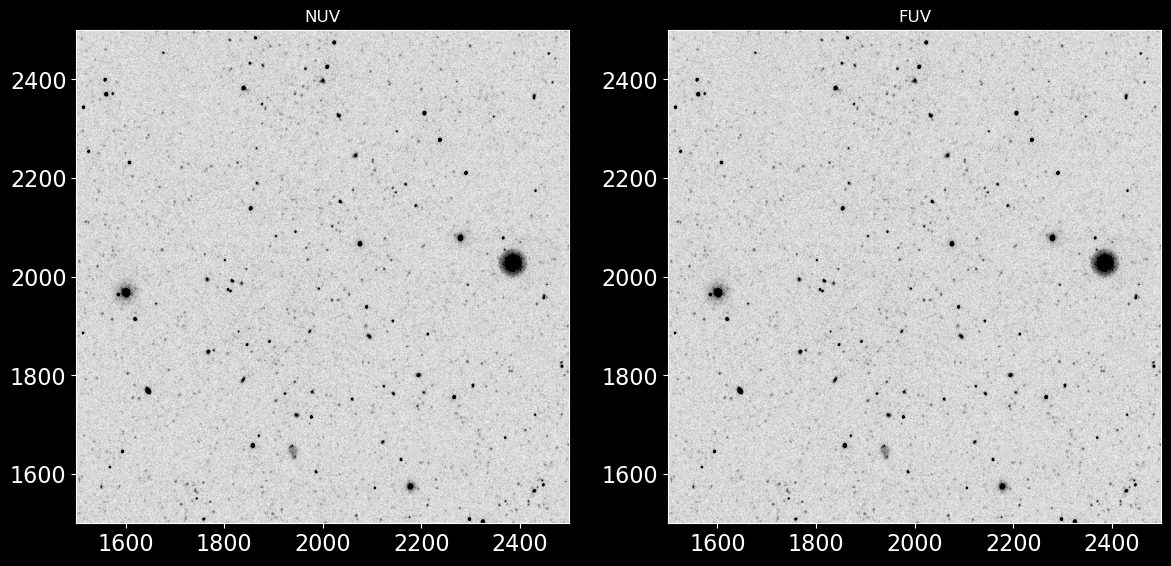

In [64]:
fig, (ax1, ax2) = plt.subplots(figsize=[14,14], facecolor="black", ncols=2)
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
ax1.spines['bottom'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.xaxis.label.set_color('white')
ax1.yaxis.label.set_color('white')
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')

ax2.spines['bottom'].set_color('white')
ax2.spines['top'].set_color('white')
ax2.spines['left'].set_color('white')
ax2.spines['right'].set_color('white')
ax2.xaxis.label.set_color('white')
ax2.yaxis.label.set_color('white')
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')

# Define o fundo dos subplots como preto
ax1.set_facecolor('black')
ax2.set_facecolor('black')

plt.subplot(1, 2, 1)
plt.title("NUV", color="white")
plt.imshow(image_nuv, cmap='gray_r',vmin=0, vmax=0.015)
for i in range(0, len(phot_table_np_nuv["xcenter"])):
    circulo = Circle((phot_table_np_nuv["xcenter"][i], phot_table_np_nuv["ycenter"][i]), radius=5, edgecolor='crimson', facecolor='none', zorder=1, linewidth=2)
    ax1.add_patch(circulo)
plt.xlim(1500, 2500)
plt.ylim(1500, 2500)

plt.subplot(1, 2, 2)
plt.title("FUV", color="white")
plt.imshow(image_fuv, cmap='gray_r',vmin=0.0, vmax=0.015)
for i in range(0, len(phot_table_np_fuv["xcenter"])):
    circulo = Circle((phot_table_np_fuv["xcenter"][i], phot_table_np_fuv["ycenter"][i]), radius=5, edgecolor='crimson', facecolor='none', zorder=1, linewidth=2)
    ax2.add_patch(circulo)
plt.xlim(1500, 2500)
plt.ylim(1500, 2500)

plt.savefig(p_directory + 'UV_image.png', format='png', dpi=100, transparent=True)
plt.show()

In [65]:
mag_nuv = -2.5 * np.log10(phot_table_nuv["aperture_sum"]) + 18.82
mag_fuv = -2.5 * np.log10(phot_table_fuv["aperture_sum"]) + 20.08


phot_table = phot_table_nuv
phot_table.rename_column('aperture_sum', 'Flux_nuv')

phot_table["Flux_fuv"] = phot_table_fuv["aperture_sum"]

phot_table["mag_fuv"] = mag_fuv
phot_table["mag_nuv"] = mag_nuv


phot_table

/tmp/ipykernel_11281/2106398977.py:1: RuntimeWarning: invalid value encountered in log10
  mag_nuv = -2.5 * np.log10(phot_table_nuv["aperture_sum"]) + 18.82
/tmp/ipykernel_11281/2106398977.py:2: RuntimeWarning: invalid value encountered in log10
  mag_fuv = -2.5 * np.log10(phot_table_fuv["aperture_sum"]) + 20.08


<Table length=23>
  id       xcenter       ...      mag_fuv            mag_nuv      
             pix         ...                                      
int64      float64       ...      float64            float64      
----- ------------------ ... ------------------ ------------------
    0 1336.6412136771542 ...  24.50909263899283 23.423849583943145
    1 1403.7951508358412 ... 23.398210989489233 22.142733515062613
    2 1321.1383767153734 ... 22.193358159350378 21.834702604538904
    3  1409.582867205324 ... 25.234954580707026  23.23749135545679
    4 1336.4670642767135 ...                nan                nan
    5 1353.0325896637032 ... 23.899008237414076  22.51530562685379
    6  1212.417387631832 ...  25.26727138238912 24.799370440422948
    7  1335.528272920096 ... 23.202845658658333  22.24231970243657
    8 1284.8795391106407 ... 23.386257657788995 22.614491580053116
  ...                ... ...                ...                ...
   14 1176.6957546265658 ...  25.17069875360592 23.818818130776894
   15 1355.4028862205018 ...  22.87490480399241 22.155898401980025
   16  1334.168541680781 ...  23.39371592173606 23.136154930509992
   17  1207.890377618266 ...  23.47883712634492 22.943036203261382
   18 1495.0085967446337 ...                nan                nan
   19  1307.879596104042 ...  23.14976003893195  22.35466931027545
   20  1390.441002180523 ...                nan                nan
   21 1245.6331412151594 ... 26.009395639194004  26.40251466306355
   22 1328.1193729092302 ...  22.95273234279476  21.70341311750341

In [66]:
fuv_nuv = mag_fuv - mag_nuv

df_five_cut["FUV - NUV"] = fuv_nuv
df_five_cut["FUV"] = mag_fuv
df_five_cut["NUV"] = mag_nuv 
df_five_cut["FLUX-fuv"] = phot_table["Flux_fuv"]
df_five_cut["FLUX-nuv"] = phot_table["Flux_nuv"]

df_five_cut

x-Image-g  y-Image-g         RA        DEC    MAG-g    MAG-r    MAG-i  \
0   1337.1118   493.3901  10.762496 -22.307064  24.8473  24.2865  23.9162   
1    954.0901   538.9393  10.732247 -22.303773  23.2102  22.4049  22.4606   
2   1425.5031   566.9491  10.769467 -22.301682  24.4751  24.1436  23.5526   
3    921.0646   581.8249  10.729635 -22.300643  24.5087  24.1117  23.3801   
4   1338.0732   580.9781  10.762562 -22.300666  24.4603  23.8259  23.8387   
5   1243.5771   626.9800  10.755096 -22.297315  23.7158  23.0050  22.8176   
6   2045.5175   737.4716  10.818400 -22.289151  24.4734  24.1062  23.6578   
7   1343.3022   921.8672  10.762938 -22.275762  23.9017  23.0736  22.7593   
8   1632.1603   948.8820  10.785739 -22.273757  23.8051  23.2165  23.0733   
9   1303.2295  1066.1462  10.759759 -22.265226  24.0471  23.6472  23.2672   
10  1185.5624  1142.9830  10.750462 -22.259624  23.1168  22.5472  22.4612   
11   544.6776  1262.7115  10.699863 -22.250931  24.4211  23.8130  23.3137   
12   905.2197  1360.3207  10.728312 -22.243772  22.2197  21.8195  21.6853   
13  1172.9099  1359.9149  10.749441 -22.243777  23.6548  23.5402  22.9952   
14  2249.0122  1376.8467  10.834373 -22.242415  24.5055  23.7812  23.3731   
15  1229.7629  1435.5624  10.753920 -22.238245  22.9511  22.3568  22.2251   
16  1350.7865  1662.7723  10.763447 -22.221634  24.1413  23.2287  23.0203   
17  2070.9998  1641.5114  10.820286 -22.223104  24.4124  24.3736  23.7923   
18   433.4984  1561.0011  10.691066 -22.229147  24.6691  24.1186  23.9872   
19  1500.7631  1547.5620  10.775296 -22.230035  23.6876  23.1259  22.7152   
20  1029.6261  2270.8789  10.738043 -22.177240  24.3429  23.6192  23.1971   
21  1855.6886  1782.2262  10.803276 -22.212851  22.4493  22.0550  21.9029   
22  1385.1244  2107.0730  10.766107 -22.189173  23.4332  22.8418  22.8086   

      MAG-z   aber-r  aber-r6  ...  3.6 - 4.5        3.6        4.5  \
0   23.7541  24.1904  25.1535  ...        NaN  20.915126        NaN   
1   22.1907  22.3638  23.1458  ...        NaN        NaN        NaN   
2   23.2877  23.9193  25.0639  ...        NaN        NaN        NaN   
3   23.0859  23.9877  24.9085  ...        NaN        NaN        NaN   
4   23.6794  23.8687  24.5629  ...        NaN        NaN        NaN   
5   22.6954  22.8985  23.8375  ...  -0.568206  22.985310  23.553516   
6   23.5460  24.0409  24.7674  ...        NaN        NaN        NaN   
7   22.5063  23.0300  23.8106  ...   0.157965  22.854522  22.696557   
8   23.0399  23.1136  23.9598  ...   0.185391  23.820910  23.635519   
9   23.0894  23.4370  24.5372  ...   0.014899  22.481710  22.466810   
10  22.4296  22.3336  23.4259  ...  -0.306677  20.213948  20.520625   
11  22.9857  23.6939  24.6161  ...        NaN        NaN        NaN   
12  21.5811  21.8509  22.5421  ...   0.632434  23.387209  22.754775   
13  22.8005  23.4356  24.3076  ...  -1.379142  22.669692  24.048834   
14  23.1264  23.7723  24.5338  ...        NaN        NaN        NaN   
15  22.1195  22.3850  23.0651  ...        NaN        NaN  25.693199   
16  22.8815  23.1321  24.0180  ...        NaN        NaN        NaN   
17  23.6693  24.3429  25.2134  ...        NaN        NaN        NaN   
18  23.8447  24.0989  24.7886  ...        NaN        NaN        NaN   
19  22.5418  23.0900  23.8816  ...        NaN  22.621935        NaN   
20  23.2207  23.6580  24.3183  ...        NaN        NaN        NaN   
21  21.6856  22.0772  22.7646  ...        NaN        NaN        NaN   
22  22.6562  22.8684  23.5879  ...        NaN        NaN  23.359852   

        FLUX-3.6      FLUX-4.5  FUV - NUV        FUV        NUV  FLUX-fuv  \
0            NaN  1.562966e-05   1.085243  24.509093  23.423850  0.016919   
1            NaN           NaN   1.255477  23.398211  22.142734  0.047067   
2            NaN -3.042075e-06   0.358656  22.193358  21.834703  0.142777   
3            NaN           NaN   1.997463  25.234955  23.237491  0.008670   
4  -3.446970e-07 -1.959257e-09        NaN        NaN        NaN -

Let's see the spread of the globular candidates on the galaxy image

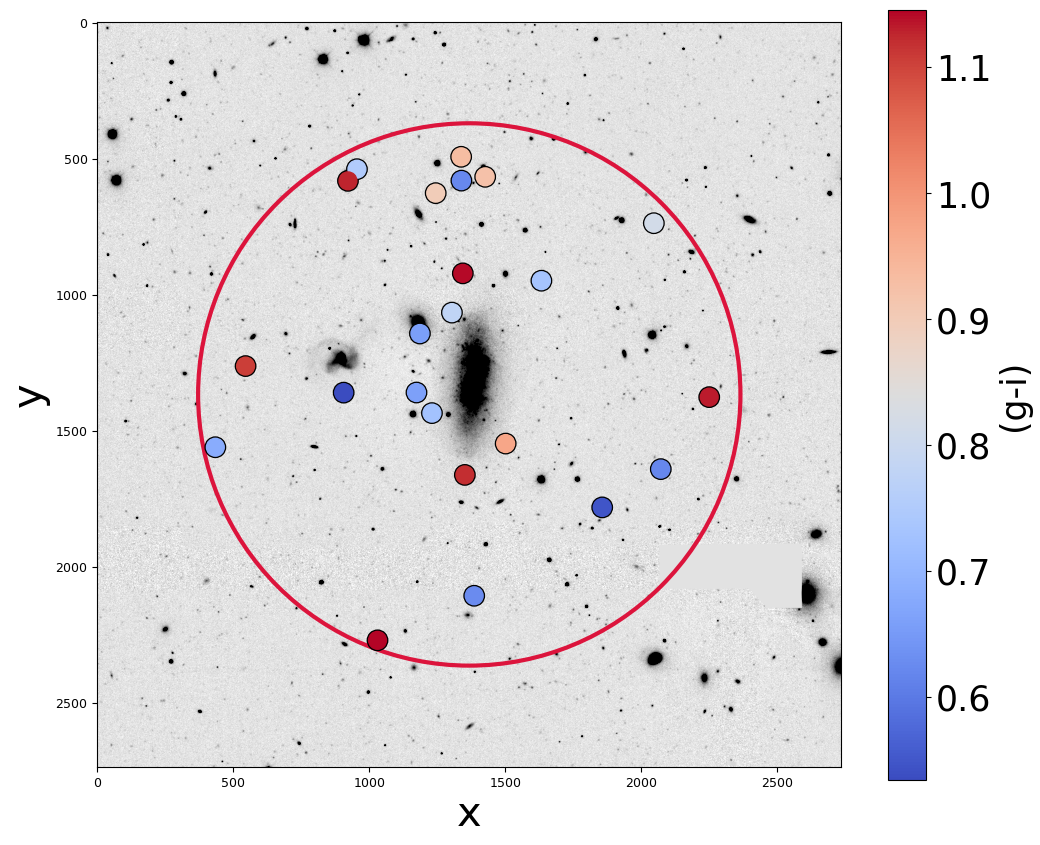

In [67]:
image = fits.open(fits_dir)[0].data.astype(float)
fig, ax = plt.subplots(figsize=[12,10], facecolor="white")
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.xlabel("x", fontsize=30, color="black")
plt.ylabel("y", fontsize=30, color="black")
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')

ax = plt.gca() 
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
#plt.ylim(2400, 4600)
#plt.xlim(650, 2850)
plt.imshow(image, cmap='gray_r',vmin=image.min()+20, vmax=image.mean()+30,  zorder=0)
circulo = Circle((center, center_y), radius=5*q_pix, edgecolor='crimson', facecolor='none', zorder=1, linewidth=3)
ax.add_patch(circulo)
#circulo = Circle((center, center_y), radius=1.2*q_pix, edgecolor='black', facecolor='none', zorder=1, linewidth=3)
#ax.add_patch(circulo)
x_reff = []
y_reff = []
for a in range(0, len(df_five_cut)):
    circulo = Circle((df_five_cut['x-Image-g'][a], df_five_cut['y-Image-g'][a]), radius=35, edgecolor='black', facecolor='none', zorder=1, linewidth=2)
    ax.add_patch(circulo)

colors_2 = df_five_cut['(g-i)']
cmap = plt.get_cmap('coolwarm')
norma = plt.Normalize(colors_2.min(), colors_2.max())

plt.scatter(df_five_cut['x-Image-g'],df_five_cut['y-Image-g'], s=165, cmap=cmap, norm=norma, c=colors_2)

cbar = plt.colorbar()
cbar.outline.set_edgecolor('black')
cbar.set_label('(g-i)',color='black',  fontsize=25)
cbar.ax.tick_params(axis='y', colors='black')

plt.savefig(p_directory + 'effective_ratius.pdf', format='pdf', dpi=500, transparent=True)
plt.show()

In [68]:
def minha_formula(x, a):
    r_gc = a
    d_gc = (1/np.pi) * (1/((r_gc**2)*(1+((x **2)/(r_gc**2)))**2))
    return np.log10(d_gc)

<>:56: SyntaxWarning: invalid escape sequence '\l'
<>:56: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_11281/3201712756.py:56: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\log_{10}(\Sigma_{plum}(r;\ r_{GC}))\ \ [N_{GC}/pix^{2}]$", fontsize = 30, color="white")


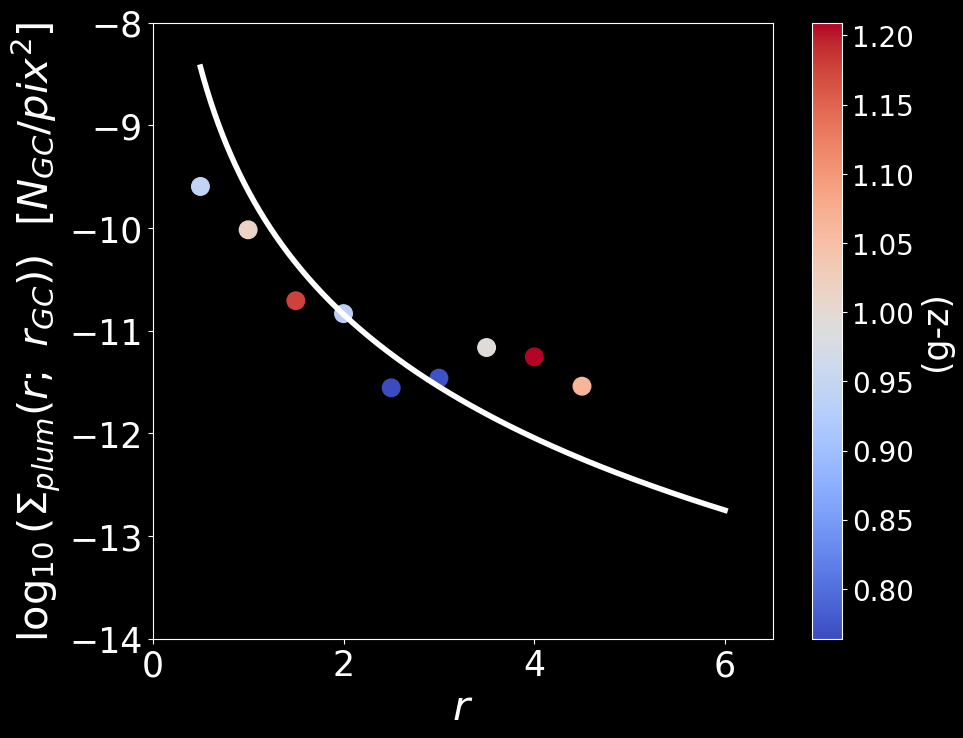

In [69]:
from scipy.optimize import curve_fit
#Define the diagram layout


plt.figure(figsize=(10, 8), facecolor='black')
plt.ylim(-13, -8)

ax = plt.gca()
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 20
#plt.gca().invert_xaxis()
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.set_facecolor('black')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')


densi_gc = []
raios_x = []
colors_r = []
M_v = []


for rai in np.arange(0, 10, 0.5):
    r_int = ((rai)*q_pix)**2
    r_ext = ((rai+0.75)*q_pix)**2
    area = (np.pi * (r_ext**2)) - (np.pi * (r_int**2))
    q_gc = len(df_five_cut['x-Image-g'][((df_five_cut['x-Image-g'] - center)**2 + (df_five_cut['y-Image-g'] - center_y)**2 <= r_ext) & 
               ((df_five_cut['x-Image-g'] - center)**2 + (df_five_cut['y-Image-g'] - center_y)**2 >= r_int)])
    col_gc = df_five_cut["(g-z)"][((df_five_cut['x-Image-g'] - center)**2 + (df_five_cut['y-Image-g'] - center_y)**2 <= r_ext) & 
               ((df_five_cut['x-Image-g'] - center)**2 + (df_five_cut['y-Image-g'] - center_y)**2 >= r_int)]
    M_g = df_five_cut["MAG-g"][((df_five_cut['x-Image-g'] - center)**2 + (df_five_cut['y-Image-g'] - center_y)**2 <= r_ext) & 
               ((df_five_cut['x-Image-g'] - center)**2 + (df_five_cut['y-Image-g'] - center_y)**2 >= r_int)]
    
    if(q_gc != 0):
        densi_gc.append(q_gc / area)
        raios_x.append(rai)
        colors_r.append(np.mean(col_gc))
        M_v.append(np.mean(M_g))

densi_gc = np.array(densi_gc)
raios_x = np.array(raios_x)
colors_r = np.array(colors_r)
M_v = np.array(M_v)

cmap = plt.get_cmap('coolwarm')
norma = plt.Normalize(colors_r.min(), colors_r.max())

plt.xlabel("$r$", fontsize = 30, color="white")
plt.ylabel("$\log_{10}(\Sigma_{plum}(r;\ r_{GC}))\ \ [N_{GC}/pix^{2}]$", fontsize = 30, color="white")

params, covariance = curve_fit(minha_formula, raios_x, np.log10(densi_gc), p0=[0.2])
a = params
rai_plot = np.linspace(0.5, 6, 1000)

plt.plot(rai_plot, minha_formula(rai_plot, a), label='Curva ajustada', color="white", linewidth=4)
plt.scatter(raios_x, np.log10(densi_gc), s=160, cmap=cmap, norm=norma, c=colors_r)
#plt.axvline(x=1, color='r', linestyle='--')
 
cbar = plt.colorbar()
cbar.outline.set_edgecolor('white')
cbar.set_label('(g-z)',color='white',  fontsize=25)
cbar.ax.tick_params(axis='y', colors='white')
#ax.vlines(1, -13, -8, color="lightgray", linestyle='--', linewidth=2)

plt.xlim(0,6.5)
plt.ylim(-14,-8)

plt.savefig(p_directory + 'densidade_globular.png', format='png', dpi=100, transparent=True)
plt.show() #(g-r) 	(r-z) 	(r-i) 	(g-i) 	(g-z)
print()

In [70]:
0.2*5*1.2

1.2

See the confidence region with the candidate globular clusters. This plot will be so important for calculating the metallicity from the sources.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


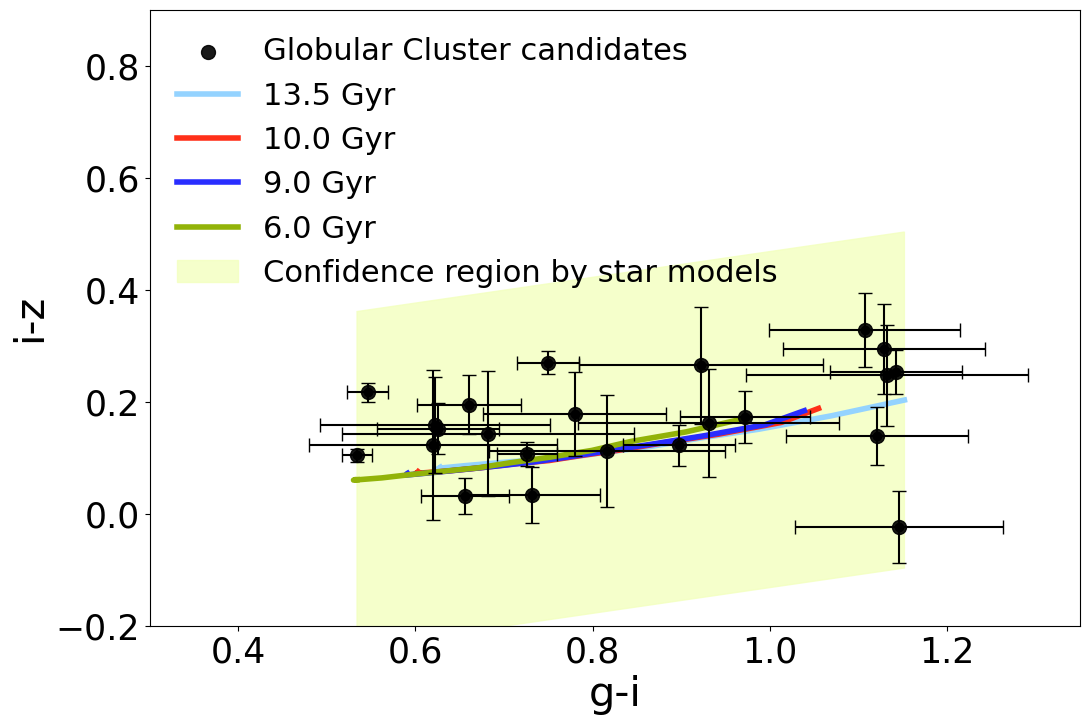

In [71]:
#Define the diagram layout
plt.figure(figsize = (12,8), facecolor='white')
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25 
plt.xlabel("g-i", fontsize=30, color="black")
plt.ylabel("i-z", fontsize=30, color="black")
plt.xlim(0.3, 1.35)
plt.ylim(-0.2, 0.9)
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')

ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')

#plt.fill([-0.5, 2.2, 2.2, -0.5], [-1.6, -1.6, 2.2, 2.2], facecolor='black', alpha=1.0, zorder=-3)


#Ṕlot the data frame with globular cluster candidates
plt.scatter(df_five_cut["(g-i)"], df_five_cut["(i-z)"], color="black", alpha=0.9, zorder = 3, label="Globular Cluster candidates", s=100)
plt.errorbar(df_five_cut["(g-i)"], df_five_cut["(i-z)"], yerr=df_five_cut["E(r-i)"], xerr=df_five_cut["E(g-i)"],fmt='o', capsize=5, color = "black", zorder=5)
#Plot the isochrones, each one represents diferent ages
plt.plot(g_i_star_model_135, i_z_star_model_135, linewidth=4, color="#94D3FF", label="13.5 Gyr")  #13.5 Gyr
plt.plot(g_i_star_model_10, i_z_star_model_10, linewidth=4, color="#FF3019", label="10.0 Gyr")  #10.0 Gyr
plt.plot(g_i_star_model_9, i_z_star_model_9, linewidth=4, color="#292DFF", label="9.0 Gyr")  #9.0 Gyr
plt.plot(g_i_star_model_6, i_z_star_model_6, linewidth=4, color="#92B309", label="6.0 Gyr")  #6.0 Gyr

#Plot the confidence region
plt.fill(xs,ys, c="#F3FFBF", zorder = 1, label="Confidence region by star models", alpha=0.8)
plt.legend(frameon=False, fontsize=22, loc='upper left', facecolor='white', edgecolor='black', labelcolor='black')

plt.savefig(p_directory + 'GC_candidates.eps', format='eps', dpi=10000, transparent=True)
plt.show()

**According to (Jordan et al. 2007) and (Escudero, 2020)**, the absolute magnitude in the V band is a universal value for all globular clusters, defined as <br> M_V = -7.4 mag. As we don't have the V band in our sample, we will use a **color relation and the distance modulus to calculate the absolute magnitude in the V band.**

In [72]:
#Calculate the magnitude V from color (g-r) relation 
V = df_five_cut["MAG-g"] - 0.496 * df_five_cut["(g-r)"] - 0.15
M_v = (-5) * np.log10(float(dis) * 10**6) + 5 + V

#Função de luminoso de raio (rai-0.5)*q_pix. O valor q_gc armazena o número de pontos dentro desse aneidade dos globulares
#M_v = M_v[M_v >= -10.5]

df_five_cut["M_v"] = M_v
#df_five_cut  = df_five_cut.dropna()
#new_index = range(0,len(df_five_cut))
#df_five_cut = df_five_cut.reset_index(drop=True)

df_five_cut 

x-Image-g  y-Image-g         RA        DEC    MAG-g    MAG-r    MAG-i  \
0   1337.1118   493.3901  10.762496 -22.307064  24.8473  24.2865  23.9162   
1    954.0901   538.9393  10.732247 -22.303773  23.2102  22.4049  22.4606   
2   1425.5031   566.9491  10.769467 -22.301682  24.4751  24.1436  23.5526   
3    921.0646   581.8249  10.729635 -22.300643  24.5087  24.1117  23.3801   
4   1338.0732   580.9781  10.762562 -22.300666  24.4603  23.8259  23.8387   
5   1243.5771   626.9800  10.755096 -22.297315  23.7158  23.0050  22.8176   
6   2045.5175   737.4716  10.818400 -22.289151  24.4734  24.1062  23.6578   
7   1343.3022   921.8672  10.762938 -22.275762  23.9017  23.0736  22.7593   
8   1632.1603   948.8820  10.785739 -22.273757  23.8051  23.2165  23.0733   
9   1303.2295  1066.1462  10.759759 -22.265226  24.0471  23.6472  23.2672   
10  1185.5624  1142.9830  10.750462 -22.259624  23.1168  22.5472  22.4612   
11   544.6776  1262.7115  10.699863 -22.250931  24.4211  23.8130  23.3137   
12   905.2197  1360.3207  10.728312 -22.243772  22.2197  21.8195  21.6853   
13  1172.9099  1359.9149  10.749441 -22.243777  23.6548  23.5402  22.9952   
14  2249.0122  1376.8467  10.834373 -22.242415  24.5055  23.7812  23.3731   
15  1229.7629  1435.5624  10.753920 -22.238245  22.9511  22.3568  22.2251   
16  1350.7865  1662.7723  10.763447 -22.221634  24.1413  23.2287  23.0203   
17  2070.9998  1641.5114  10.820286 -22.223104  24.4124  24.3736  23.7923   
18   433.4984  1561.0011  10.691066 -22.229147  24.6691  24.1186  23.9872   
19  1500.7631  1547.5620  10.775296 -22.230035  23.6876  23.1259  22.7152   
20  1029.6261  2270.8789  10.738043 -22.177240  24.3429  23.6192  23.1971   
21  1855.6886  1782.2262  10.803276 -22.212851  22.4493  22.0550  21.9029   
22  1385.1244  2107.0730  10.766107 -22.189173  23.4332  22.8418  22.8086   

      MAG-z   aber-r  aber-r6  ...        3.6        4.5      FLUX-3.6  \
0   23.7541  24.1904  25.1535  ...  20.915126        NaN           NaN   
1   22.1907  22.3638  23.1458  ...        NaN        NaN           NaN   
2   23.2877  23.9193  25.0639  ...        NaN        NaN           NaN   
3   23.0859  23.9877  24.9085  ...        NaN        NaN           NaN   
4   23.6794  23.8687  24.5629  ...        NaN        NaN -3.446970e-07   
5   22.6954  22.8985  23.8375  ...  22.985310  23.553516  1.375921e-06   
6   23.5460  24.0409  24.7674  ...        NaN        NaN           NaN   
7   22.5063  23.0300  23.8106  ...  22.854522  22.696557  3.029544e-06   
8   23.0399  23.1136  23.9598  ...  23.820910  23.635519  1.275828e-06   
9   23.0894  23.4370  24.5372  ...  22.481710  22.466810  3.743482e-06   
10  22.4296  22.3336  23.4259  ...  20.213948  20.520625  2.247760e-05   
11  22.9857  23.6939  24.6161  ...        NaN        NaN           NaN   
12  21.5811  21.8509  22.5421  ...  23.387209  22.754775  2.871375e-06   
13  22.8005  23.4356  24.3076  ...  22.669692  24.048834  8.718993e-07   
14  23.1264  23.7723  24.5338  ...        NaN        NaN           NaN   
15  22.1195  22.3850  23.0651  ...        NaN  25.693199  1.917433e-07   
16  22.8815  23.1321  24.0180  ...        NaN        NaN -1.301928e-06   
17  23.6693  24.3429  25.2134  ...        NaN        NaN           NaN   
18  23.8447  24.0989  24.7886  ...        NaN        NaN           NaN   
19  22.5418  23.0900  23.8816  ...  22.621935        NaN -3.351318e-07   
20  23.2207  23.6580  24.3183  ...        NaN        NaN -2.362719e-06   
21  21.6856  22.0772  22.7646  ...        NaN        NaN           NaN   
22  22.6562  22.8684  23.5879  ...        NaN  23.359852  1.644597e-06   

        FLUX-4.5  FUV - NUV        FUV        NUV  FLUX-fuv  FLUX-nuv  \
0   1.562966e-05   1.085243  24.509093  23.423850  0.016919  0.014403   
1            NaN   1.255477  23.398211  22.142734  0.047067  0.046871   
2  -3.042075e-06   0.358656  22.193358  21.834703  0.142777  0.062247   
3            NaN   1.997463  25.234955  23.237491  0.008670  0.017100   
4  -1.959257e

Thus, we will **plot a Gaussian on a magnitude in the V band diagram to observe the behavior**. This can improve the reliability of the globular cluster candidates.

<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_11281/1450238477.py:21: SyntaxWarning: invalid escape sequence '\s'
  ax.vlines(mu, 0, ymax, color="#FF3019", linestyle='--', label=f"Média em {mu:.2f} com $\sigma =${std:.2f}")


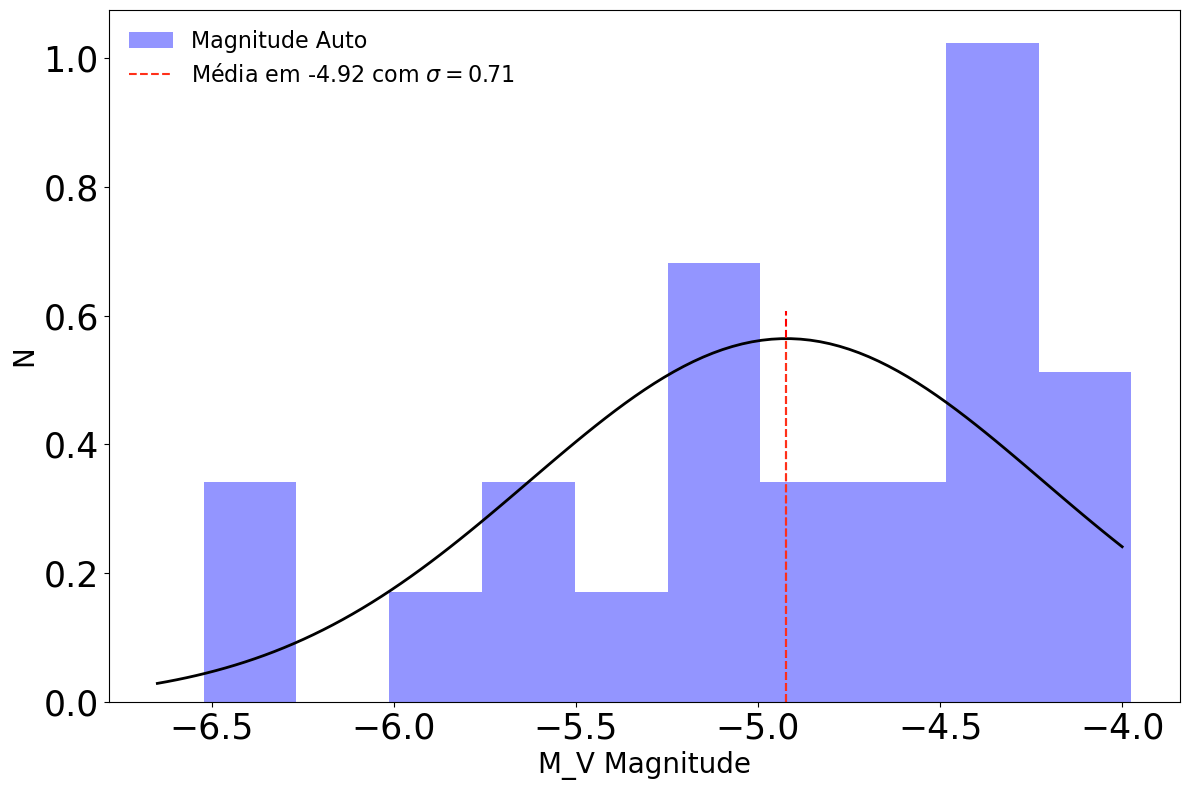

In [73]:
#Define the diagram layout
fig, ax = plt.subplots(figsize=(12, 8), sharey=True, tight_layout=True, facecolor='white')
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.xlabel("M_V Magnitude", fontsize=20)
plt.ylabel("N", fontsize=20)

#Plot a histogram
bins = ax.hist(M_v, bins=10, color="#292DFF", label="Magnitude Auto", density=True, alpha=0.5)

#Calculate the limits and plot a gaussian
mu, std = norm.fit(M_v) #Adjust a normalized (gaussian) spread which mu is the average and std the standard deviation
xmin, xmax = plt.xlim()
x = np.linspace(xmin, -4.0, 100) #Create a sequence of 100 numbers between xmin e xmax 
p = norm.pdf(x, mu, std) 
ax.plot(x, p, 'k', linewidth=2)

#Calculate the max value of the gaussian
ymax = np.max(p)
ax.axvline(x=mu, ymin=0, ymax=ymax, color='r', linestyle='--')
ax.vlines(mu, 0, ymax, color="#FF3019", linestyle='--', label=f"Média em {mu:.2f} com $\sigma =${std:.2f}")

#Finish the diagram layout
plt.legend(frameon=False, fontsize=16, loc='upper left')

plt.savefig(p_directory + 'M_V_Gaussian.png', format='png', dpi=float(d), transparent=True)
plt.show()

<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_11281/3139356007.py:21: SyntaxWarning: invalid escape sequence '\s'
  ax.vlines(mu, 0, ymax, color="#FF3019", linestyle='--', label=f"Média em {mu:.2f} com $\sigma =${std:.2f}")


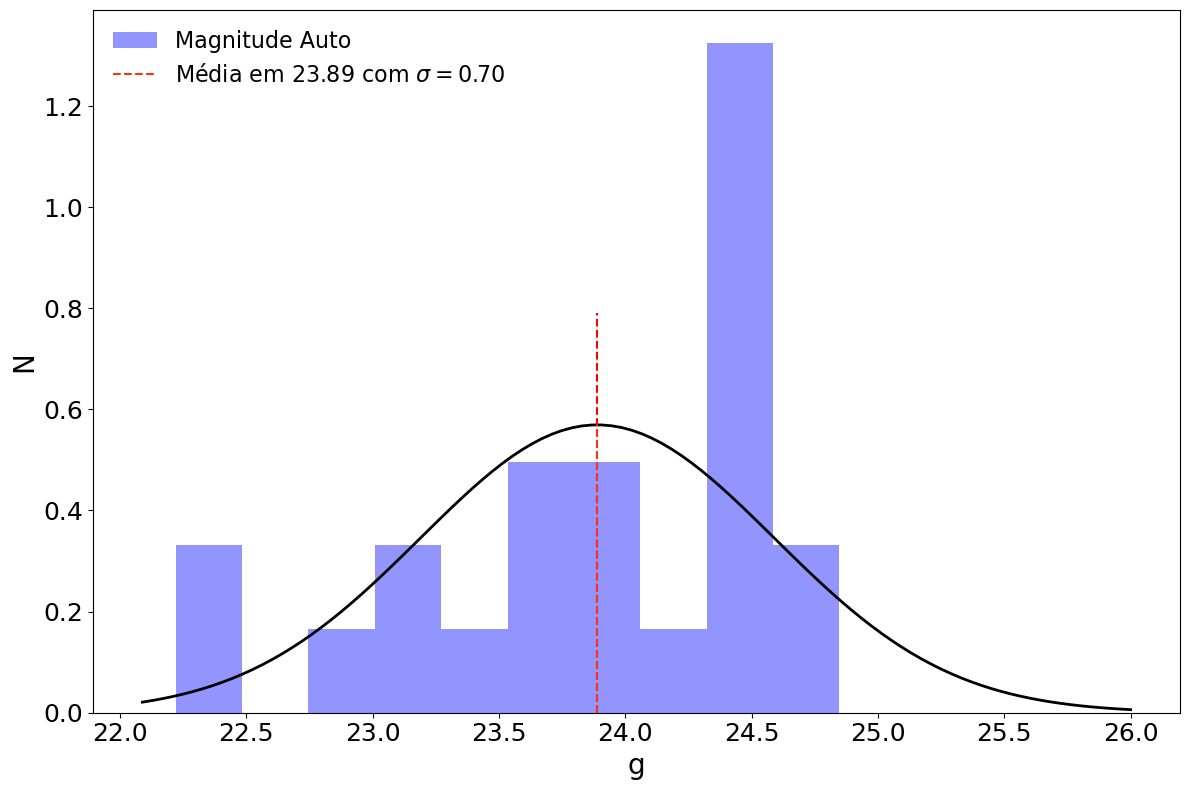

In [74]:
#Define the diagram layout
fig, ax = plt.subplots(figsize=(12, 8), sharey=True, tight_layout=True, facecolor='white')
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.xlabel("g", fontsize=20)
plt.ylabel("N", fontsize=20)

#Plot a histogram
bins = ax.hist(df_five_cut["MAG-g"] , bins=10, color="#292DFF", label="Magnitude Auto", density=True, alpha=0.5)

#Calculate the limits and plot a gaussian
mu, std = norm.fit(df_five_cut["MAG-g"]) #Adjust a normalized (gaussian) spread which mu is the average and std the standard deviation
xmin, xmax = plt.xlim()
x = np.linspace(xmin, 26, 100) #Create a sequence of 100 numbers between xmin e xmax 
p = norm.pdf(x, mu, std) 
ax.plot(x, p, 'k', linewidth=2)

#Calculate the max value of the gaussian
ymax = np.max(p)
ax.axvline(x=mu, ymin=0, ymax=ymax, color='r', linestyle='--')
ax.vlines(mu, 0, ymax, color="#FF3019", linestyle='--', label=f"Média em {mu:.2f} com $\sigma =${std:.2f}")

#Finish the diagram layout
plt.legend(frameon=False, fontsize=16, loc='upper left')

plt.savefig(p_directory + 'M_V_Gaussian.png', format='png', dpi=float(d), transparent=True)
plt.show()

Another important diagram is the **color-magnitude diagram**, which can be seen below using two colors.

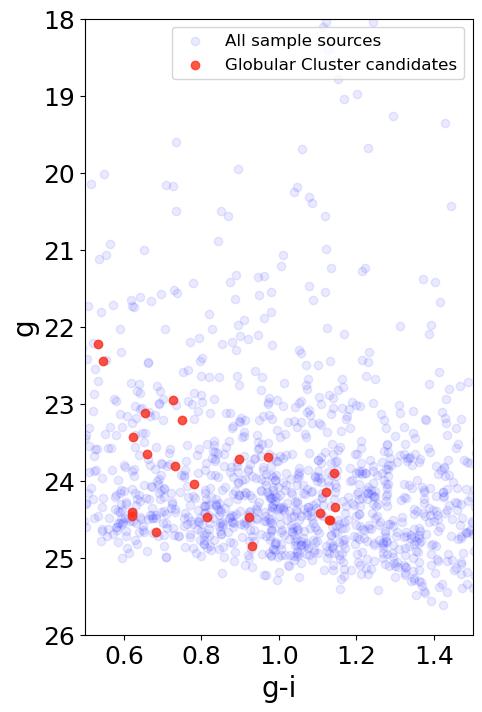

In [75]:
#Define the diagram layout
plt.figure(figsize = (5,8), facecolor='white')
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

plt.xlabel("g-i", fontsize=20)
plt.ylabel("g", fontsize=20)
plt.xlim(0.5,1.5)
plt.ylim(18,26) 
plt.gca().invert_yaxis()
#Plot the sample 
plt.scatter(df["(g-i)"],df["MAG-g"], color="#292DFF", alpha=0.1, zorder=0, label="All sample sources")
plt.scatter(df_five_cut["(g-i)"], df_five_cut["MAG-g"], color="#FF3019", alpha=0.8, zorder=1, label="Globular Cluster candidates")
#Finish the diagram layout
plt.legend(fontsize=12, loc='upper right')

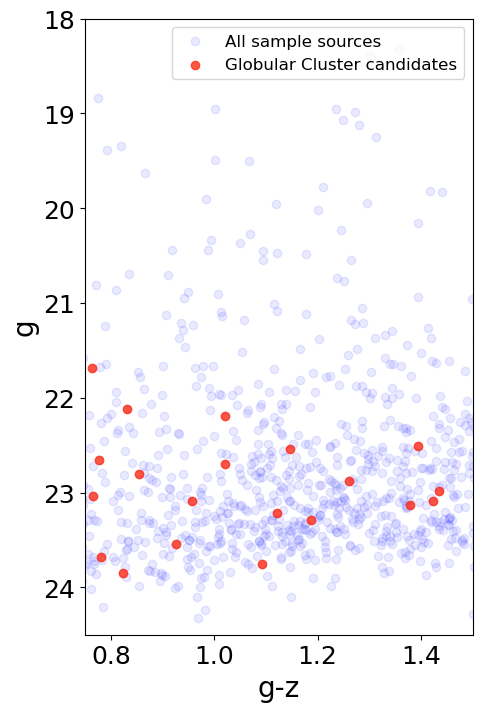

In [76]:
plt.figure(figsize = (5,8), facecolor='white')
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

plt.xlabel("g-z", fontsize=20)
plt.ylabel("g", fontsize=20)
plt.xlim(0.75,1.5)
plt.ylim(18,24.5)
plt.gca().invert_yaxis()
#Plot the sample
plt.scatter(df["(g-z)"],df["MAG-z"], color="#292DFF", alpha=0.1, zorder=0, label="All sample sources")
plt.scatter(df_five_cut["(g-z)"], df_five_cut["MAG-z"], color="#FF3019", alpha=0.8, zorder=1, label="Globular Cluster candidates")
plt.legend(fontsize=12, loc='upper right')
#Finish the diagram layout
plt.savefig(p_directory + 'color_mag.png', format='png', dpi=float(d), transparent=True)
plt.show()

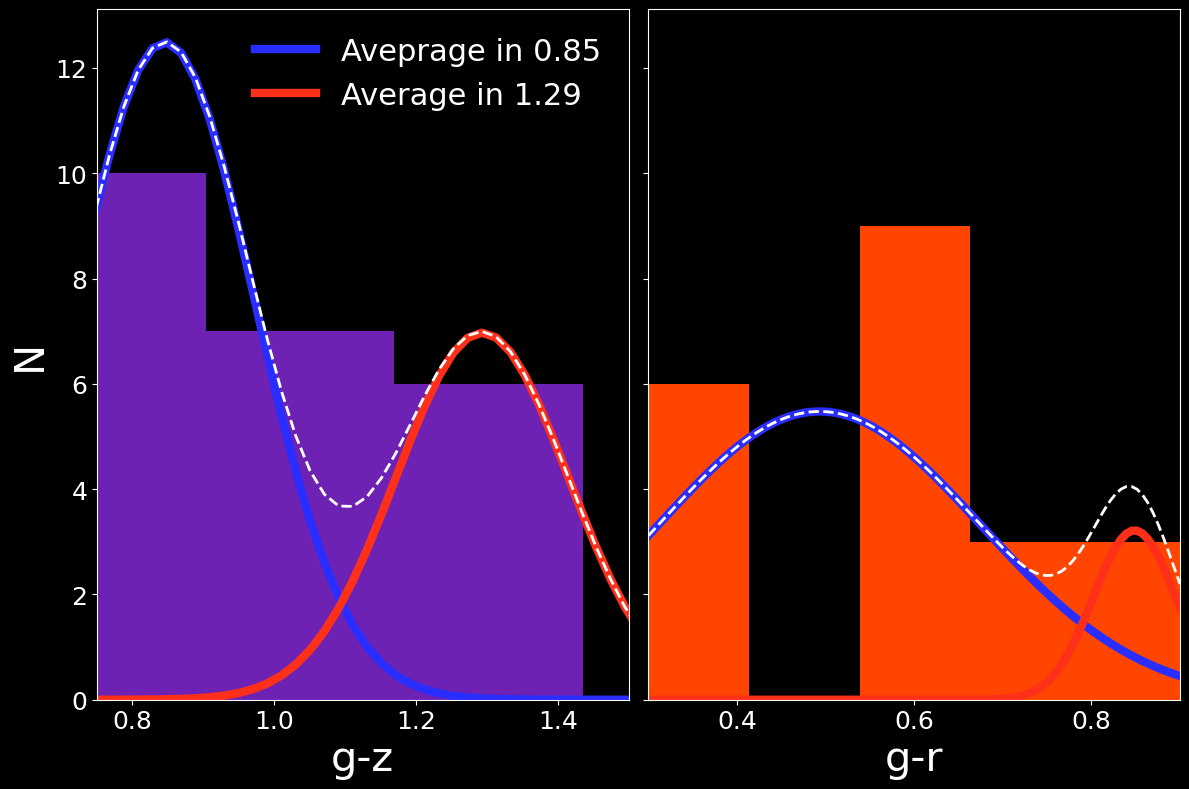

In [77]:
# Define o diagrama layout15.321081324783531	15.47270324551
fig , (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 8), sharey=True, tight_layout=True, facecolor='black')
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
# Define as cores dos eixos e legendas como branco
ax1.spines['bottom'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.xaxis.label.set_color('white')
ax1.yaxis.label.set_color('white')
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')

ax2.spines['bottom'].set_color('white')
ax2.spines['top'].set_color('white')
ax2.spines['left'].set_color('white')
ax2.spines['right'].set_color('white')
ax2.xaxis.label.set_color('white')
ax2.yaxis.label.set_color('white') 
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')

# Define o fundo dos subplots como preto
ax1.set_facecolor('black')
ax2.set_facecolor('black')

# Define o layout dos subplots


# Define o layout do primeiro subplot
plt.subplot(1, 2, 1)
n1, bins1, patches1 = ax1.hist(df_five_cut["(g-z)"], bins=3, color="blueviolet", alpha=0.8)
ax1.set_xlim(0.75, 1.5)
ax1.set_xlabel("g-z", fontsize=30)
ax1.set_ylabel("N", fontsize=30)

# Ajusta uma gaussiana a cada pico
peak1_mean, peak1_std = norm.fit(df_five_cut["(g-z)"].loc[df_five_cut["(g-z)"] < 1.1])
peak2_mean, peak2_std = norm.fit(df_five_cut["(g-z)"].loc[df_five_cut["(g-z)"] >= 1.1])

# Define as propriedades e plota as gaussianas
norm_factor1 = len(df_five_cut.loc[df_five_cut["(g-z)"] < 1.1]) * np.diff(bins1)[0]
norm_factor2 = len(df_five_cut.loc[df_five_cut["(g-z)"] >= 1.1]) * np.diff(bins1)[0]
#RA e DECAccessAccess
#NGC2101     86.600708 -52.088528
x1 = np.linspace(0,2, 100)
y11 = norm.pdf(x1, peak1_mean, peak1_std)
y12 = norm.pdf(x1, peak2_mean, peak2_std)
ax1.plot(x1, y11 * norm_factor1, "#292DFF", linewidth=6, label=f"Aveprage in {peak1_mean:.2f}")
ax1.plot(x1, y12 * norm_factor2, "#FF3019", linewidth=6, label=f"Average in {peak2_mean:.2f}")
y_total = (y11 * norm_factor1) + (y12 * norm_factor2)
ax1.plot(x1, y_total, 'white', linewidth=2, linestyle='--')
plt.legend(frameon=False, fontsize=22, loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')


#plt.subplot(1, 2, 2)ago
# Define o layout do segundo subplot
n2, bins2, patches2 = ax2.hist(df_five_cut["(g-r)"], bins=7, color="orangered", alpha=1)
ax2.set_xlim(0.3, 0.9)
ax2.set_xlabel("g-r", fontsize=30)

# Ajusta uma gaussiana a cada picoi
peak1_mean, peak1_std = norm.fit(df_five_cut["(g-r)"].loc[df_five_cut["(g-r)"] < 0.75])
peak2_mean, peak2_std = norm.fit(df_five_cut["(g-r)"].loc[df_five_cut["(g-r)"] >= 0.75])
# Define as propriedades e plota as gaussianas
norm_factor1 = len(df_five_cut.loc[df_five_cut["(g-r)"] < 0.75]) * np.diff(bins2)[0]
norm_factor2 = len(df_five_cut.loc[df_five_cut["(g-r)"] >= 0.75]) * np.diff(bins2)[0]
x2 = np.linspace(0.3, 0.9, 100)
y21 = norm.pdf(x2, peak1_mean, peak1_std)
y22 = norm.pdf(x2, peak2_mean, peak2_std)
ax2.plot(x2, y21 * norm_factor1, "#292DFF", linewidth=6, label=f"Average in {peak1_mean:.2f}")
ax2.plot(x2, y22 * norm_factor2, "#FF3019", linewidth=6, label=f"Average in {peak2_mean:.2f}")
y_total = (y21 * norm_factor1) + (y22 * norm_factor2)
ax2.plot(x2, y_total, 'white', linewidth=2,linestyle='--')

plt.legend(frameon=False, fontsize=22, loc='upper right', facecolor='black', edgecolor='white', labelcolor='white')

# Salva o gráfico
plt.savefig(p_directory + 'bimodality.png', format='png', dpi=200, transparent=True)
plt.show()

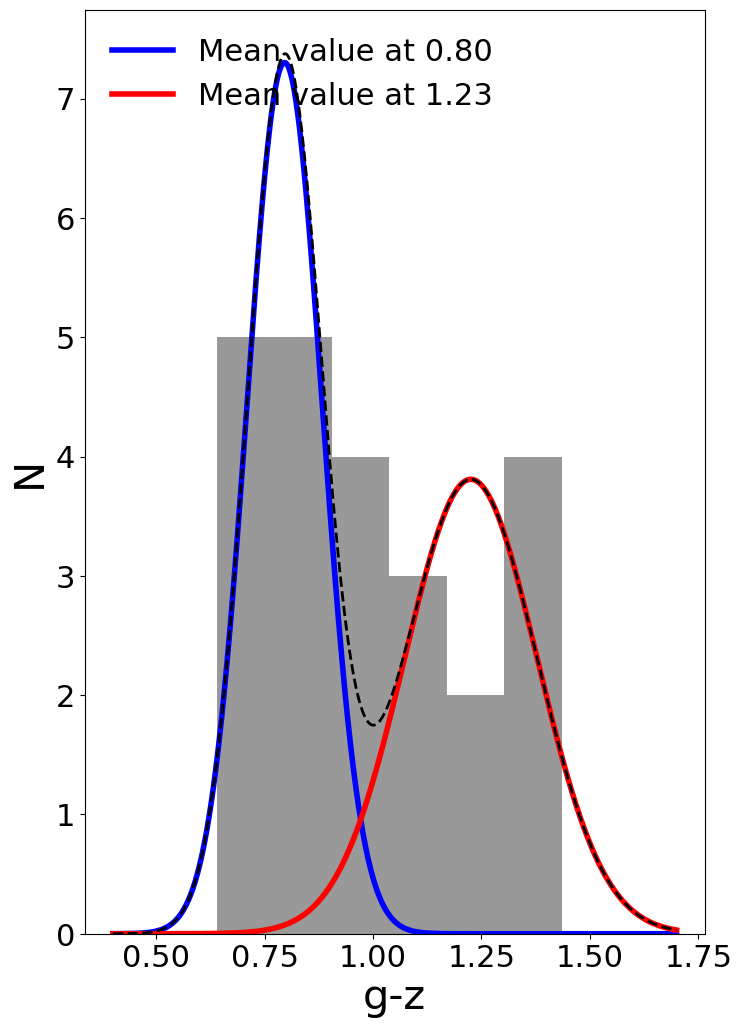

In [78]:
plt.figure(figsize=(8, 12), facecolor='white')

n1, bins1, patches1 = plt.hist(df_five_cut["(g-z)"], bins=6, color="gray", alpha=0.8)
#plt.xlim(0.3, 1)
#plt.ylim(0, 9)
plt.xlabel("g-z", fontsize=30)
plt.ylabel("N", fontsize=30)

# Ajusta uma gaussiana a cada pico
peak1_mean, peak1_std = norm.fit(df_five_cut["(g-z)"].loc[df_five_cut["(g-z)"] < 1.])
peak2_mean, peak2_std = norm.fit(df_five_cut["(g-z)"].loc[df_five_cut["(g-z)"] >= 1.])

# Define as propriedades e plota as gaussianas
norm_factor1 = len(df_five_cut.loc[df_five_cut["(g-z)"] < 1.]) * np.diff(bins1)[0]
norm_factor2 = len(df_five_cut.loc[df_five_cut["(g-z)"] >= 1.]) * np.diff(bins1)[0]

x1 = np.linspace(0.4,1.7, 1000)
y11 = norm.pdf(x1, peak1_mean, peak1_std)
y12 = norm.pdf(x1, peak2_mean, peak2_std)
plt.plot(x1, y11 * norm_factor1, "blue", linewidth=4, label=f"Mean value at {peak1_mean:.2f}")
plt.plot(x1, y12 * norm_factor2, "red", linewidth=4, label=f"Mean value at {peak2_mean:.2f}")
y_total = (y11 * norm_factor1) + (y12 * norm_factor2)
plt.plot(x1, y_total, 'black', linewidth=2, linestyle='--')
plt.legend(frameon=False, fontsize=22, loc='upper left', facecolor='black', edgecolor='black', labelcolor='black')

plt.savefig(p_directory + 'bimodality_one.pdf', format='pdf', dpi=3500, transparent=True)
plt.show()

To conclude, we will write a CSV file containing all the parameters we have obtained for our globular cluster candidates. This will facilitate the visualization of these sources on SAO DS9, allowing us to print their image coordinates.

In [79]:
x = df_five_cut["x-Image-g"]
y = df_five_cut["y-Image-g"]

for i in range(len(df_five_cut)):
    print(str(df_five_cut["x-Image-g"][i]) + " " + str(df_five_cut[ "y-Image-g"][i]))
    58.7858 -43.5391

df_five_cut.to_csv(f_directory + "big_interval", sep=' ', index=False)

1337.1118 493.3901
954.0901 538.9393
1425.5031 566.9491
921.0646 581.8249
1338.0732 580.9781
1243.5771 626.98
2045.5175 737.4716
1343.3022 921.8672
1632.1603 948.882
1303.2295 1066.1462
1185.5624 1142.983
544.6776 1262.7115
905.2197 1360.3207
1172.9099 1359.9149
2249.0122 1376.8467
1229.7629 1435.5624
1350.7865 1662.7723
2070.9998 1641.5114
433.4984 1561.0011
1500.7631 1547.562
1029.6261 2270.8789
1855.6886 1782.2262
1385.1244 2107.073


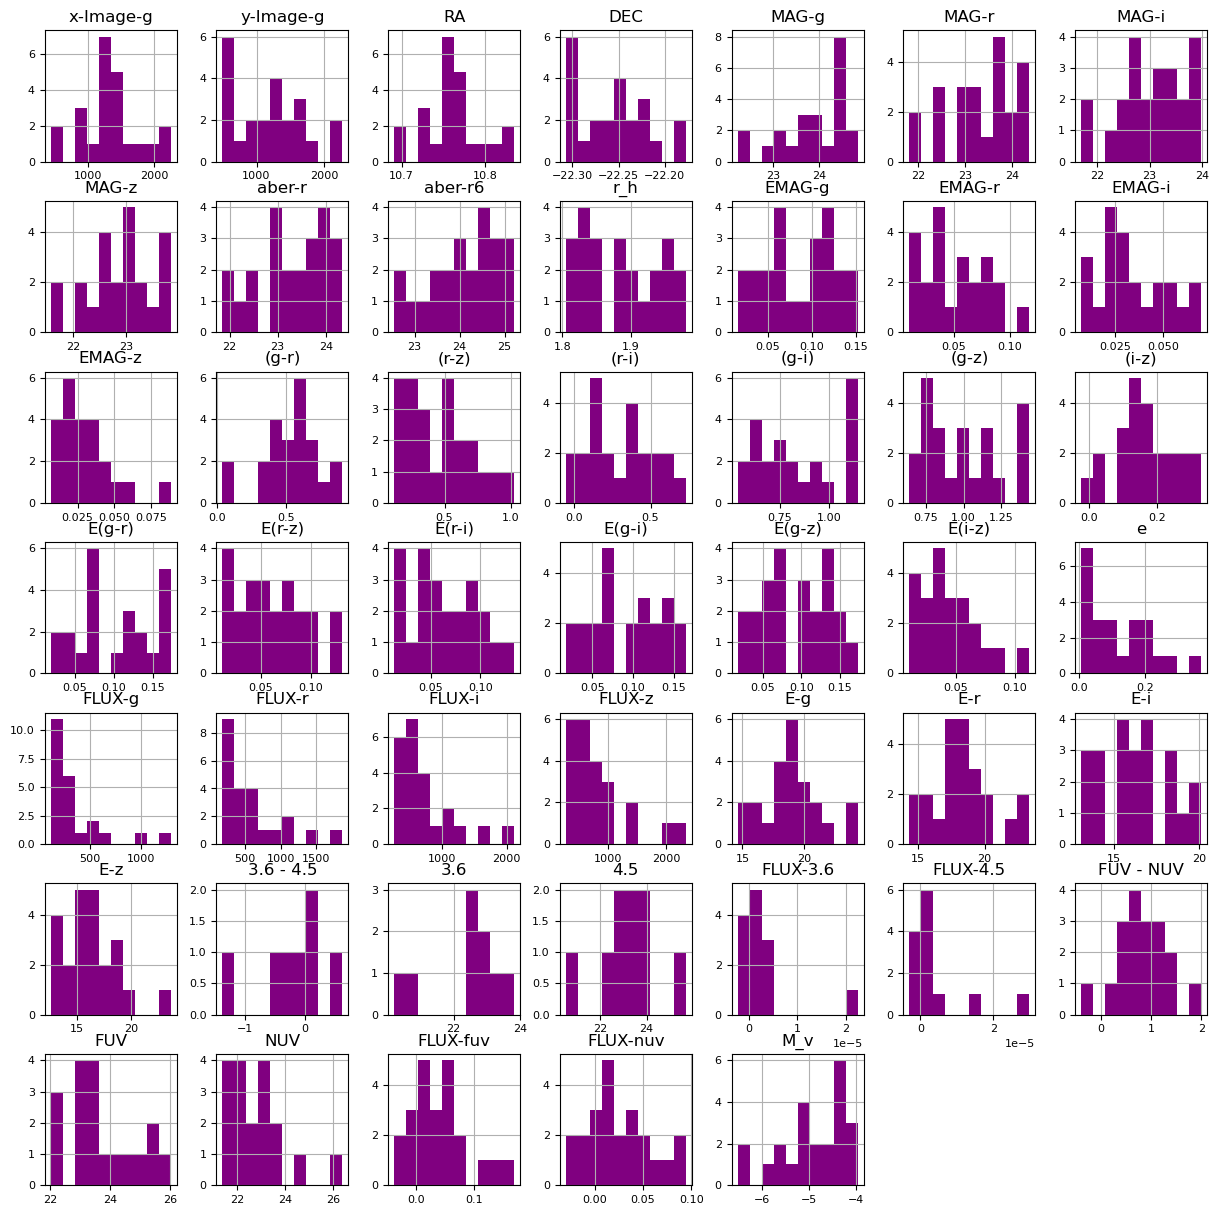

In [80]:
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
df_five_cut.hist(color="purple", alpha=1.0, bins=10, figsize=[15,15])
plt.show()

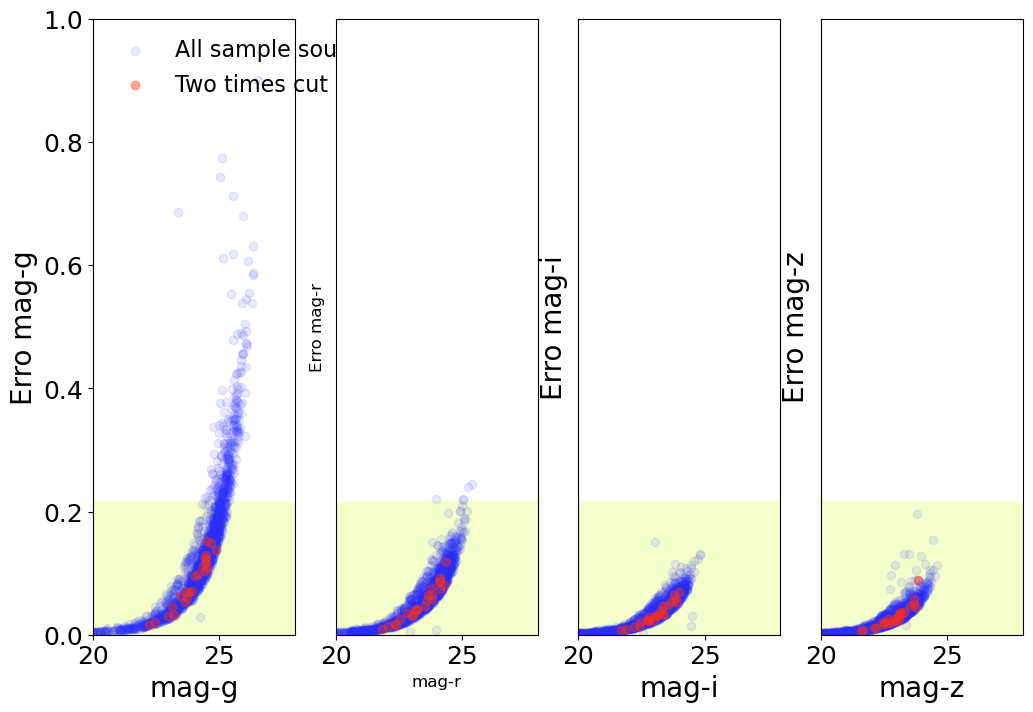

In [81]:
#Define the diagram layout
plt.figure(figsize=(12, 8), facecolor='white')
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18


#Before plotting the error diagram from the g band, we need to define the subplot layout
plt.subplot(1, 4, 1)
plt.ylim(0,1)
plt.xlim(20, 28)
plt.xlabel("mag-g", fontsize = 20)
plt.ylabel("Erro mag-g", fontsize = 20)
#Plot the no cuted catalog samples
plt.scatter(df["MAG-g"], df["EMAG-g"], color="#292DFF", alpha=0.1, zorder=1, label="All sample sources")
#Plot the yet cuted catalog samples
plt.scatter(df_five_cut["MAG-g"], df_five_cut["EMAG-g"], color="#FF3019", alpha=0.4, zorder=2, label="Two times cut sources")
#Draw a region with the confidence magnitude error
plt.axhspan(0, erro_max, color="#F3FFBF", alpha=0.8, zorder=0)
plt.legend(frameon=False, fontsize=16, loc='upper left')

#Before plotting the error diagram from the r band, we need to define the subplot layout
plt.subplot(1, 4, 2)
plt.ylim(0,1)
plt.xlim(20, 28)
plt.yticks([])
plt.xlabel("mag-r", fontsize = 12)
plt.ylabel("Erro mag-r", fontsize = 12)
#Plot the no cuted catalog samples
plt.scatter(df["MAG-r"], df["EMAG-r"], color="#292DFF", alpha=0.1, zorder=1)
#Plot the yet cuted catalog samples
plt.scatter(df_five_cut["MAG-r"], df_five_cut["EMAG-r"], color="#FF3019", alpha=0.4, zorder=2)
#Draw a region with the confidence magnitude error
plt.axhspan(0, erro_max, color="#F3FFBF", alpha=0.8, zorder=0)

#Before plotting the Uma outraerror diagram from the i band, we need to define the subplot layout
plt.subplot(1, 4, 3)
plt.ylim(0,1)
plt.xlim(20, 28)
plt.yticks([])
plt.xlabel("mag-i", fontsize = 20)
plt.ylabel("Erro mag-i", fontsize = 20)
#Plot the no cuted catalog samples
plt.scatter(df["MAG-i"], df["EMAG-i"], color="#292DFF", alpha=0.1, zorder=1)
#Plot the yet cuted catalog samples
plt.scatter(df_five_cut["MAG-i"], df_five_cut["EMAG-i"], color="#FF3019", alpha=0.4, zorder=2)
#Draw a region with the confidence magnitude error
plt.axhspan(0, erro_max, color="#F3FFBF", alpha=0.8, zorder=0)

#Before plotting the error diagram from the z band, we need to define the subplot layout
plt.subplot(1, 4, 4)
plt.ylim(0,1)
plt.xlim(20, 28)
plt.yticks([])
plt.xlabel("mag-z", fontsize = 20)
plt.ylabel("Erro mag-z", fontsize = 20)
#Plot the no cuted catalog samples
plt.scatter(df["MAG-z"], df["EMAG-z"], color="#292DFF", alpha=0.1, zorder=1)
#Plot the yet cuted catalog samplese
plt.scatter(df_five_cut["MAG-z"], df_five_cut["EMAG-z"], color="#FF3019", alpha=0.4, zorder=2)
#Draw a region with the confidence magnitude error
plt.axhspan(0, erro_max, color="#F3FFBF", alpha=0.8, zorder=0)

plt.savefig(p_directory + 'errorS.png', format='png', dpi=float(d), transparent=True)
plt.show()